In [245]:
import cv2

original_img = cv2.imread('./images/flappy_bird.png')

In [246]:
original_img

array([[[ 74, 189, 135],
        [ 74, 189, 135],
        [ 74, 189, 135],
        ...,
        [206, 193, 131],
        [206, 193, 131],
        [206, 193, 131]],

       [[ 74, 189, 135],
        [ 74, 189, 135],
        [ 74, 189, 135],
        ...,
        [206, 193, 131],
        [206, 193, 131],
        [206, 193, 131]],

       [[ 74, 189, 135],
        [ 74, 189, 135],
        [ 74, 189, 135],
        ...,
        [206, 193, 131],
        [206, 193, 131],
        [206, 193, 131]],

       ...,

       [[ 74, 189, 135],
        [ 74, 189, 135],
        [ 74, 189, 135],
        ...,
        [164, 212, 163],
        [164, 213, 163],
        [164, 213, 163]],

       [[ 74, 189, 135],
        [ 74, 189, 135],
        [ 74, 189, 135],
        ...,
        [149, 206, 149],
        [148, 207, 149],
        [148, 207, 149]],

       [[ 74, 189, 135],
        [ 74, 189, 135],
        [ 74, 189, 135],
        ...,
        [138, 204, 139],
        [137, 204, 139],
        [136, 204, 139]]

In [247]:
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

def preprocess(prev_frame: Path | str, current_frame: Path | str) -> Path | str:
    # Read the input frames to get a 3D array: (rows x cols x channels)
    prev_img = cv2.imread(str(prev_frame))
    current_img = cv2.imread(str(current_frame))
    new_frame = np.maximum(prev_img, current_img)
    gray_img = cv2.cvtColor(new_frame, cv2.COLOR_BGR2GRAY)
    rescaled_img = cv2.resize(gray_img, (84, 84), interpolation=cv2.INTER_AREA)
    plt.imshow(rescaled_img, cmap="gray", interpolation="nearest")
    plt.show()
    return rescaled_img

def preprocess_frame(frame: np.ndarray) -> np.ndarray:
    """
    Preprocess a single frame for DQN input.
    
    Args:
        frame: RGB frame from env.render() with shape (H, W, 3) or (H, W)
        
    Returns:
        Preprocessed grayscale frame of shape (84, 84) with values normalized to [0, 1]
    """
    # Convert RGB to grayscale if needed
    if len(frame.shape) == 3:
        gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    else:
        gray = frame
    
    # Resize to 84x84
    resized = cv2.resize(gray, (84, 84), interpolation=cv2.INTER_AREA)
    
    # Normalize to [0, 1] range
    normalized = resized.astype(np.float32) / 255.0
    
    return normalized

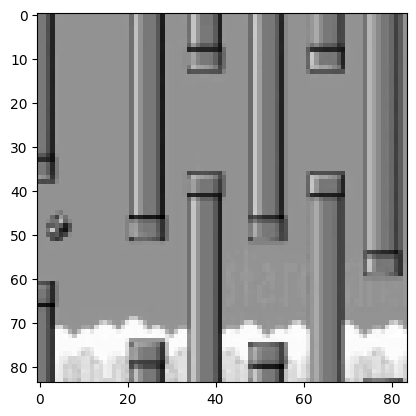

array([[160, 160, 134, ..., 125, 141, 176],
       [160, 160, 135, ..., 125, 142, 178],
       [160, 160, 135, ..., 125, 143, 177],
       ...,
       [160, 160, 134, ..., 236, 230, 219],
       [160, 160, 134, ..., 232, 229, 219],
       [160, 160, 134, ..., 139, 133, 206]], shape=(84, 84), dtype=uint8)

In [248]:
prev_frame = "./images/flappy_bird.png"
current_frame = "./images/flappy_bird.png"

preprocess(prev_frame, current_frame)

In [249]:
def conv2d_output_size(input_size, kernel_size, stride, padding=0):
    """
    Calculate the output size of a 2D convolutional layer.
    
    Formula: output_size = (input_size - kernel_size + 2*padding) / stride + 1
    
    Args:
        input_size: Input height/width (int or tuple)
        kernel_size: Kernel size (int or tuple)
        stride: Stride (int or tuple)
        padding: Padding (int or tuple, default=0)
    
    Returns:
        Output size (int or tuple)
    """
    if isinstance(input_size, tuple):
        # Handle tuple input (height, width)
        h, w = input_size
        
        # Handle kernel_size - convert int to tuple if needed
        if isinstance(kernel_size, tuple):
            k_h, k_w = kernel_size
        else:
            k_h = k_w = kernel_size
        
        # Handle stride - convert int to tuple if needed
        if isinstance(stride, tuple):
            s_h, s_w = stride
        else:
            s_h = s_w = stride
        
        # Handle padding - convert int to tuple if needed
        if isinstance(padding, tuple):
            p_h, p_w = padding
        else:
            p_h = p_w = padding
        
        o_h = (h - k_h + 2 * p_h) // s_h + 1
        o_w = (w - k_w + 2 * p_w) // s_w + 1
        return (int(o_h), int(o_w))
    else:
        # Handle single dimension
        k = kernel_size if isinstance(kernel_size, int) else kernel_size[0]
        s = stride if isinstance(stride, int) else stride[0]
        p = padding if isinstance(padding, int) else padding[0]
        return int((input_size - k + 2 * p) // s + 1)

In [250]:
class FrameBuffer:
    """
    Maintains a buffer of the last 4 preprocessed frames.
    Handles initial steps by repeating the first frame.
    """
    
    def __init__(self, frame_shape=(84, 84)):
        self.frame_shape = frame_shape
        self.buffer = np.zeros((4, *frame_shape), dtype=np.float32)
        self.count = 0
    
    def add_frame(self, frame: np.ndarray) -> np.ndarray:
        """
        Add a new frame to the buffer and return stacked frames.
        
        Args:
            frame: Preprocessed frame of shape (84, 84)
            
        Returns:
            Stacked frames of shape (4, 84, 84) ready for DQN input
        """
        # For the first frame, fill the buffer with the same frame
        if self.count == 0:
            self.buffer[:] = frame
        else:
            # Shift frames: remove oldest, add newest
            self.buffer = np.roll(self.buffer, -1, axis=0)
            self.buffer[-1] = frame
        
        self.count += 1
        return self.buffer.copy()
    
    def reset(self):
        """Reset the buffer (call when environment resets)."""
        self.buffer.fill(0)
        self.count = 0
    
    def get_stacked_frames(self) -> np.ndarray:
        """Get current stacked frames without adding a new frame."""
        return self.buffer.copy()


In [251]:
def process_observation(observation, frame_buffer: FrameBuffer, env) -> np.ndarray:
    """
    Process a raw observation into DQN-ready input.
    
    Args:
        observation: Raw observation from env (may be vector or None)
        frame_buffer: FrameBuffer instance
        env: Environment instance (for rendering)
        
    Returns:
        Stacked frames of shape (4, 84, 84) ready for DQN
    """
    # Render to get RGB frame
    rgb_frame = env.render()
    
    # Preprocess the frame
    processed_frame = preprocess_frame(rgb_frame)
    
    # Add to buffer and get stacked frames
    stacked = frame_buffer.add_frame(processed_frame)
    
    return stacked


In [253]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DQN(nn.Module):
    """
    Deep Q-Network as in Mnih et al. (2015)
    Input: (B, 4, 84, 84)
    Output: Q-values for each action
    """

    def __init__(self, num_actions):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
        )

        # compute conv output size dynamically
        with torch.no_grad():
            dummy = torch.zeros(1, 4, 84, 84)
            n_flat = self.conv(dummy).view(1, -1).size(1)

        self.fc = nn.Sequential(
            nn.Linear(n_flat, 512),
            nn.ReLU(),
            nn.Linear(512, num_actions),
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.reshape(x.size(0), -1)
        return self.fc(x)


In [254]:
# Test the DQN model architecture
# Create a model instance
model = DQN(num_actions=2)

# Create a dummy input: batch_size=1, 4 stacked frames, 84x84 grayscale
dummy_input = torch.randn(1, 4, 84, 84)

# Forward pass
with torch.no_grad():
    output = model(dummy_input)

print(f"Model architecture:")
print(model)
print(f"\nInput shape: {dummy_input.shape}")
print(f"Output shape: {output.shape}")
print(f"Expected output shape: (1, 2) - one Q-value per action")
print(f"\nQ-values: {output}")


Model architecture:
DQN(
  (conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=2, bias=True)
  )
)

Input shape: torch.Size([1, 4, 84, 84])
Output shape: torch.Size([1, 2])
Expected output shape: (1, 2) - one Q-value per action

Q-values: tensor([[-0.0353, -0.0244]])


In [255]:
import random
from collections import deque


class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)
        return state, action, reward, next_state, done

    def __len__(self):
        return len(self.buffer)


In [256]:
import numpy as np


class DQNAgent:
    def __init__(
        self,
        q_net,
        num_actions,
        eps_start=1.0,
        eps_end=0.1,
        eps_decay_steps=1_000_000,
    ):
        self.q_net = q_net
        self.num_actions = num_actions

        self.eps_start = eps_start
        self.eps_end = eps_end
        self.eps_decay_steps = eps_decay_steps
        self.steps_done = 0

    def epsilon(self):
        frac = min(self.steps_done / self.eps_decay_steps, 1.0)
        return self.eps_start + frac * (self.eps_end - self.eps_start)

    def act(self, state):
        self.steps_done += 1

        if np.random.rand() < self.epsilon():
            return np.random.randint(self.num_actions)

        with torch.no_grad():
            q_values = self.q_net(state.unsqueeze(0))
            return q_values.argmax(dim=1).item()


In [257]:
import torch.optim as optim


class DQNTrainer:
    def __init__(
        self,
        q_net,
        target_net,
        replay_buffer,
        gamma=0.99,
        lr=2.5e-4,
        batch_size=32,
        target_update_freq=10_000,
        device="cpu",
    ):
        self.q_net = q_net.to(device)
        self.target_net = target_net.to(device)
        self.target_net.load_state_dict(self.q_net.state_dict())
        self.target_net.eval()

        self.buffer = replay_buffer
        self.gamma = gamma
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq
        self.device = device

        self.optimizer = optim.RMSprop(
            self.q_net.parameters(),
            lr=lr,
            alpha=0.95,
            eps=0.01,
        )

        # Huber loss = clipped TD error (paper)
        self.loss_fn = nn.SmoothL1Loss()

        self.train_steps = 0

    def train_step(self):
        if len(self.buffer) < self.batch_size:
            return

        state, action, reward, next_state, done = self.buffer.sample(
            self.batch_size
        )

        # Convert numpy arrays to tensors before stacking
        # States are numpy arrays of shape (4, 84, 84), need to convert to tensors first
        state = torch.stack([torch.FloatTensor(s) for s in state]).to(self.device)
        next_state = torch.stack([torch.FloatTensor(s) for s in next_state]).to(self.device)
        action = torch.tensor(action).to(self.device)
        reward = torch.tensor(reward).to(self.device)
        done = torch.tensor(done).to(self.device)

        # Q(s, a)
        q_values = self.q_net(state)
        q_sa = q_values.gather(1, action.unsqueeze(1)).squeeze(1)

        # target: r + γ max_a' Q̂(s', a')
        with torch.no_grad():
            next_q = self.target_net(next_state).max(1)[0]
            # Convert done to float tensor for arithmetic operations
            target = reward + self.gamma * next_q * (1 - done.float())

        loss = self.loss_fn(q_sa, target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # periodic target update
        if self.train_steps % self.target_update_freq == 0:
            self.target_net.load_state_dict(self.q_net.state_dict())

        self.train_steps += 1


In [258]:
!pip install flappy-bird-gymnasium

In [259]:
import gymnasium as gym

env = gym.make("FlappyBird-v0")

In [260]:
# Check the environment properties
print(f"Action space: {env.action_space}")
print(f"Observation space: {env.observation_space}")

# Reset the environment to get initial state
observation, info = env.reset()
print(f"Initial observation shape: {observation.shape}")

# Take a random action
action = env.action_space.sample()
observation, reward, terminated, truncated, info = env.step(action)
print(f"Reward: {reward}, Terminated: {terminated}")

# Close the environment when done
env.close()

Action space: Discrete(2)
Observation space: Box(0.0, 1.0, (180,), float64)
Initial observation shape: (180,)
Reward: 0.1, Terminated: False


In [261]:
# Test the preprocessing pipeline
import gymnasium as gym

# Create environment with rgb_array render mode to get pixel observations
env = gym.make("FlappyBird-v0", render_mode='rgb_array')
frame_buffer = FrameBuffer()

# Reset environment
observation, info = env.reset()

# Process first observation
stacked_frames = process_observation(observation, frame_buffer, env)
print(f"Stacked frames shape: {stacked_frames.shape}")
print(f"Expected: (4, 84, 84)")
print(f"Frame buffer count: {frame_buffer.count}")
print(f"Frame value range: [{stacked_frames.min():.3f}, {stacked_frames.max():.3f}]")

# Take a few steps to test frame stacking
for i in range(3):
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    stacked_frames = process_observation(observation, frame_buffer, env)
    print(f"Step {i+1}: Stacked frames shape: {stacked_frames.shape}, count: {frame_buffer.count}")

# Test reset
frame_buffer.reset()
print(f"\nAfter reset - buffer count: {frame_buffer.count}")
print(f"Buffer after reset (should be all zeros): {np.allclose(frame_buffer.buffer, 0)}")

env.close()
print("\n✓ Preprocessing pipeline test completed successfully!")


Stacked frames shape: (4, 84, 84)
Expected: (4, 84, 84)
Frame buffer count: 1
Frame value range: [0.329, 0.957]
Step 1: Stacked frames shape: (4, 84, 84), count: 2
Step 2: Stacked frames shape: (4, 84, 84), count: 3
Step 3: Stacked frames shape: (4, 84, 84), count: 4

After reset - buffer count: 0
Buffer after reset (should be all zeros): True

✓ Preprocessing pipeline test completed successfully!


In [262]:
# Training loop with visualization
import gymnasium as gym
import torch
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt

# Install tqdm if not available: !pip install tqdm
try:
    from tqdm import tqdm
except ImportError:
    print("tqdm not found. Install with: !pip install tqdm")
    # Fallback: use range instead of tqdm
    def tqdm(iterable, desc=""):
        return iterable

# Hyperparameters
NUM_EPISODES = 4000
MAX_STEPS_PER_EPISODE = 1000
REPLAY_BUFFER_SIZE = 10000
BATCH_SIZE = 32
LEARNING_RATE = 2.5e-4
GAMMA = 0.99
TARGET_UPDATE_FREQ = 100
EPS_START = 1.0
EPS_END = 0.1
EPS_DECAY_STEPS = 10000
MIN_REPLAY_SIZE = 1000

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create environment
env = gym.make("FlappyBird-v0", render_mode='rgb_array')
num_actions = env.action_space.n
print(f"Number of actions: {num_actions}")

# Initialize networks
q_net = DQN(num_actions).to(device)
target_net = DQN(num_actions).to(device)
target_net.load_state_dict(q_net.state_dict())
target_net.eval()

# Initialize components
replay_buffer = ReplayBuffer(REPLAY_BUFFER_SIZE)
frame_buffer = FrameBuffer()
trainer = DQNTrainer(
    q_net=q_net,
    target_net=target_net,
    replay_buffer=replay_buffer,
    gamma=GAMMA,
    lr=LEARNING_RATE,
    batch_size=BATCH_SIZE,
    target_update_freq=TARGET_UPDATE_FREQ,
    device=device
)
agent = DQNAgent(
    q_net=q_net,
    num_actions=num_actions,
    eps_start=EPS_START,
    eps_end=EPS_END,
    eps_decay_steps=EPS_DECAY_STEPS
)

# Tracking metrics
episode_rewards = []
episode_lengths = []
losses = []
epsilon_values = []

print("\nStarting training...")
print(f"Will train for {NUM_EPISODES} episodes")
print(f"Training will start after {MIN_REPLAY_SIZE} experiences are collected\n")


Using device: cpu
Number of actions: 2

Starting training...
Will train for 4000 episodes
Training will start after 1000 experiences are collected



In [263]:
# Training loop
for episode in tqdm(range(NUM_EPISODES), desc="Training"):
    # Reset environment and frame buffer
    observation, info = env.reset()
    frame_buffer.reset()
    
    # Get initial state
    state = process_observation(observation, frame_buffer, env)
    state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)  # Add batch dimension
    
    episode_reward = 0
    episode_length = 0
    
    for step in range(MAX_STEPS_PER_EPISODE):
        # Select action
        epsilon = agent.epsilon()
        epsilon_values.append(epsilon)
        
        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                q_values = agent.q_net(state_tensor)
                action = q_values.argmax(1).item()
        
        agent.steps_done += 1
        
        # Take step in environment
        next_observation, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        
        # Process next observation
        next_state = process_observation(next_observation, frame_buffer, env)
        next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0).to(device)
        
        # Store experience in replay buffer (state is already numpy array from process_observation)
        replay_buffer.push(
            state=state,  # Already numpy array
            action=action,
            reward=reward,
            next_state=next_state,  # Already numpy array
            done=done
        )
        
        episode_reward += reward
        episode_length += 1
        
        # Train if we have enough experiences
        if len(replay_buffer) >= MIN_REPLAY_SIZE:
            trainer.train_step()
        
        # Update state
        state = next_state
        state_tensor = next_state_tensor
        
        if done:
            break
    
    # Record episode metrics
    episode_rewards.append(episode_reward)
    episode_lengths.append(episode_length)
    
    # Print progress every 10 episodes
    if (episode + 1) % 10 == 0:
        avg_reward = np.mean(episode_rewards[-10:])
        avg_length = np.mean(episode_lengths[-10:])
        current_eps = agent.epsilon()
        print(f"\nEpisode {episode + 1}/{NUM_EPISODES}")
        print(f"  Average reward (last 10): {avg_reward:.2f}")
        print(f"  Average length (last 10): {avg_length:.1f}")
        print(f"  Current epsilon: {current_eps:.3f}")
        print(f"  Replay buffer size: {len(replay_buffer)}")

env.close()
print("\n✓ Training completed!")


Training:   0%|          | 10/4000 [00:02<13:29,  4.93it/s]


Episode 10/4000
  Average reward (last 10): -7.62
  Average length (last 10): 50.0
  Current epsilon: 0.955
  Replay buffer size: 500


Training:   0%|          | 20/4000 [00:04<14:57,  4.44it/s]


Episode 20/4000
  Average reward (last 10): -7.56
  Average length (last 10): 50.0
  Current epsilon: 0.910
  Replay buffer size: 1000


Training:   1%|          | 30/4000 [00:36<3:43:16,  3.37s/it]


Episode 30/4000
  Average reward (last 10): -7.56
  Average length (last 10): 50.0
  Current epsilon: 0.865
  Replay buffer size: 1500


Training:   1%|          | 40/4000 [01:11<3:50:42,  3.50s/it]


Episode 40/4000
  Average reward (last 10): -7.92
  Average length (last 10): 50.0
  Current epsilon: 0.820
  Replay buffer size: 2000


Training:   1%|▏         | 50/4000 [01:46<3:52:30,  3.53s/it]


Episode 50/4000
  Average reward (last 10): -7.86
  Average length (last 10): 50.0
  Current epsilon: 0.775
  Replay buffer size: 2500


Training:   2%|▏         | 60/4000 [02:21<3:50:05,  3.50s/it]


Episode 60/4000
  Average reward (last 10): -7.56
  Average length (last 10): 50.0
  Current epsilon: 0.730
  Replay buffer size: 3000


Training:   2%|▏         | 70/4000 [02:56<3:50:32,  3.52s/it]


Episode 70/4000
  Average reward (last 10): -7.08
  Average length (last 10): 50.0
  Current epsilon: 0.685
  Replay buffer size: 3500


Training:   2%|▏         | 80/4000 [03:32<3:55:20,  3.60s/it]


Episode 80/4000
  Average reward (last 10): -6.78
  Average length (last 10): 50.0
  Current epsilon: 0.640
  Replay buffer size: 4000


Training:   2%|▏         | 90/4000 [04:02<3:10:27,  2.92s/it]


Episode 90/4000
  Average reward (last 10): -7.32
  Average length (last 10): 50.0
  Current epsilon: 0.595
  Replay buffer size: 4500


Training:   2%|▎         | 100/4000 [04:32<3:07:51,  2.89s/it]


Episode 100/4000
  Average reward (last 10): -7.74
  Average length (last 10): 50.0
  Current epsilon: 0.550
  Replay buffer size: 5000


Training:   3%|▎         | 110/4000 [05:03<3:16:04,  3.02s/it]


Episode 110/4000
  Average reward (last 10): -8.34
  Average length (last 10): 50.0
  Current epsilon: 0.505
  Replay buffer size: 5500


Training:   3%|▎         | 120/4000 [05:31<2:59:44,  2.78s/it]


Episode 120/4000
  Average reward (last 10): -5.52
  Average length (last 10): 50.0
  Current epsilon: 0.460
  Replay buffer size: 6000


Training:   3%|▎         | 130/4000 [06:00<3:03:25,  2.84s/it]


Episode 130/4000
  Average reward (last 10): -4.80
  Average length (last 10): 50.0
  Current epsilon: 0.415
  Replay buffer size: 6500


Training:   4%|▎         | 140/4000 [06:27<2:53:30,  2.70s/it]


Episode 140/4000
  Average reward (last 10): -6.72
  Average length (last 10): 50.0
  Current epsilon: 0.370
  Replay buffer size: 7000


Training:   4%|▍         | 150/4000 [06:54<2:54:50,  2.72s/it]


Episode 150/4000
  Average reward (last 10): -7.44
  Average length (last 10): 50.0
  Current epsilon: 0.325
  Replay buffer size: 7500


Training:   4%|▍         | 160/4000 [07:21<2:54:02,  2.72s/it]


Episode 160/4000
  Average reward (last 10): -5.40
  Average length (last 10): 50.0
  Current epsilon: 0.280
  Replay buffer size: 8000


Training:   4%|▍         | 170/4000 [07:48<2:54:21,  2.73s/it]


Episode 170/4000
  Average reward (last 10): -4.68
  Average length (last 10): 50.0
  Current epsilon: 0.235
  Replay buffer size: 8500


Training:   4%|▍         | 180/4000 [08:15<2:51:40,  2.70s/it]


Episode 180/4000
  Average reward (last 10): -4.32
  Average length (last 10): 50.0
  Current epsilon: 0.190
  Replay buffer size: 9000


Training:   5%|▍         | 190/4000 [08:42<2:51:51,  2.71s/it]


Episode 190/4000
  Average reward (last 10): -5.22
  Average length (last 10): 50.0
  Current epsilon: 0.145
  Replay buffer size: 9500


Training:   5%|▌         | 200/4000 [09:09<2:51:01,  2.70s/it]


Episode 200/4000
  Average reward (last 10): -5.22
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:   5%|▌         | 210/4000 [09:39<3:06:31,  2.95s/it]


Episode 210/4000
  Average reward (last 10): -5.52
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:   6%|▌         | 220/4000 [10:07<3:00:53,  2.87s/it]


Episode 220/4000
  Average reward (last 10): -4.51
  Average length (last 10): 51.4
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:   6%|▌         | 230/4000 [10:35<2:54:23,  2.78s/it]


Episode 230/4000
  Average reward (last 10): -4.65
  Average length (last 10): 50.3
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:   6%|▌         | 240/4000 [11:03<2:54:09,  2.78s/it]


Episode 240/4000
  Average reward (last 10): -4.32
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:   6%|▋         | 250/4000 [11:31<2:53:27,  2.78s/it]


Episode 250/4000
  Average reward (last 10): -5.94
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:   6%|▋         | 260/4000 [11:59<2:54:23,  2.80s/it]


Episode 260/4000
  Average reward (last 10): -5.28
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:   7%|▋         | 270/4000 [12:27<2:58:42,  2.87s/it]


Episode 270/4000
  Average reward (last 10): -2.28
  Average length (last 10): 50.6
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:   7%|▋         | 280/4000 [12:57<2:55:47,  2.84s/it]


Episode 280/4000
  Average reward (last 10): -3.96
  Average length (last 10): 51.2
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:   7%|▋         | 290/4000 [13:24<2:52:45,  2.79s/it]


Episode 290/4000
  Average reward (last 10): -4.08
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:   8%|▊         | 300/4000 [13:52<2:55:17,  2.84s/it]


Episode 300/4000
  Average reward (last 10): -3.42
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:   8%|▊         | 310/4000 [14:20<2:50:34,  2.77s/it]


Episode 310/4000
  Average reward (last 10): -4.08
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:   8%|▊         | 320/4000 [14:48<2:53:36,  2.83s/it]


Episode 320/4000
  Average reward (last 10): -5.64
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:   8%|▊         | 330/4000 [15:17<2:51:10,  2.80s/it]


Episode 330/4000
  Average reward (last 10): -2.36
  Average length (last 10): 50.4
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:   8%|▊         | 340/4000 [15:45<2:49:41,  2.78s/it]


Episode 340/4000
  Average reward (last 10): -3.96
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:   9%|▉         | 350/4000 [16:13<2:48:23,  2.77s/it]


Episode 350/4000
  Average reward (last 10): -4.18
  Average length (last 10): 50.2
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:   9%|▉         | 360/4000 [16:40<2:46:59,  2.75s/it]


Episode 360/4000
  Average reward (last 10): -2.40
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:   9%|▉         | 370/4000 [17:11<3:28:52,  3.45s/it]


Episode 370/4000
  Average reward (last 10): -3.30
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  10%|▉         | 380/4000 [17:45<3:01:17,  3.00s/it]


Episode 380/4000
  Average reward (last 10): -5.28
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  10%|▉         | 390/4000 [18:17<3:20:36,  3.33s/it]


Episode 390/4000
  Average reward (last 10): -3.18
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  10%|█         | 400/4000 [18:46<2:47:36,  2.79s/it]


Episode 400/4000
  Average reward (last 10): -2.56
  Average length (last 10): 50.2
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  10%|█         | 410/4000 [19:16<3:13:29,  3.23s/it]


Episode 410/4000
  Average reward (last 10): -2.56
  Average length (last 10): 50.2
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  10%|█         | 420/4000 [19:45<2:49:00,  2.83s/it]


Episode 420/4000
  Average reward (last 10): -1.98
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  11%|█         | 430/4000 [20:13<2:41:29,  2.71s/it]


Episode 430/4000
  Average reward (last 10): -3.30
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  11%|█         | 440/4000 [20:40<2:42:33,  2.74s/it]


Episode 440/4000
  Average reward (last 10): -2.10
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  11%|█▏        | 450/4000 [21:08<2:44:55,  2.79s/it]


Episode 450/4000
  Average reward (last 10): -2.58
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  12%|█▏        | 460/4000 [21:37<2:54:02,  2.95s/it]


Episode 460/4000
  Average reward (last 10): -3.06
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  12%|█▏        | 470/4000 [22:11<3:16:43,  3.34s/it]


Episode 470/4000
  Average reward (last 10): -2.30
  Average length (last 10): 50.4
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  12%|█▏        | 480/4000 [22:40<2:53:52,  2.96s/it]


Episode 480/4000
  Average reward (last 10): -2.40
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  12%|█▏        | 490/4000 [23:09<2:55:42,  3.00s/it]


Episode 490/4000
  Average reward (last 10): -1.56
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  12%|█▎        | 500/4000 [23:40<3:04:34,  3.16s/it]


Episode 500/4000
  Average reward (last 10): -1.92
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  13%|█▎        | 510/4000 [24:10<2:51:05,  2.94s/it]


Episode 510/4000
  Average reward (last 10): -1.02
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  13%|█▎        | 520/4000 [24:39<2:46:48,  2.88s/it]


Episode 520/4000
  Average reward (last 10): -1.92
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  13%|█▎        | 530/4000 [25:08<2:49:19,  2.93s/it]


Episode 530/4000
  Average reward (last 10): -1.32
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  14%|█▎        | 540/4000 [25:36<2:39:35,  2.77s/it]


Episode 540/4000
  Average reward (last 10): -1.20
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  14%|█▍        | 550/4000 [26:04<2:49:16,  2.94s/it]


Episode 550/4000
  Average reward (last 10): -1.20
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  14%|█▍        | 560/4000 [26:33<2:50:07,  2.97s/it]


Episode 560/4000
  Average reward (last 10): -1.50
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  14%|█▍        | 570/4000 [27:13<3:11:11,  3.34s/it]


Episode 570/4000
  Average reward (last 10): -1.20
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  14%|█▍        | 580/4000 [27:42<2:43:33,  2.87s/it]


Episode 580/4000
  Average reward (last 10): -2.08
  Average length (last 10): 50.8
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  15%|█▍        | 590/4000 [28:11<2:40:25,  2.82s/it]


Episode 590/4000
  Average reward (last 10): -1.38
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  15%|█▌        | 600/4000 [28:39<2:42:03,  2.86s/it]


Episode 600/4000
  Average reward (last 10): -1.41
  Average length (last 10): 50.3
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  15%|█▌        | 610/4000 [29:08<2:39:04,  2.82s/it]


Episode 610/4000
  Average reward (last 10): -0.90
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  16%|█▌        | 620/4000 [29:36<2:41:47,  2.87s/it]


Episode 620/4000
  Average reward (last 10): -1.38
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  16%|█▌        | 630/4000 [30:05<2:40:54,  2.86s/it]


Episode 630/4000
  Average reward (last 10): -0.99
  Average length (last 10): 50.3
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  16%|█▌        | 640/4000 [30:34<2:40:25,  2.86s/it]


Episode 640/4000
  Average reward (last 10): -1.02
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  16%|█▋        | 650/4000 [31:03<2:40:38,  2.88s/it]


Episode 650/4000
  Average reward (last 10): -2.52
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  16%|█▋        | 660/4000 [31:32<2:39:00,  2.86s/it]


Episode 660/4000
  Average reward (last 10): -1.02
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  17%|█▋        | 670/4000 [32:03<2:53:35,  3.13s/it]


Episode 670/4000
  Average reward (last 10): -0.98
  Average length (last 10): 51.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  17%|█▋        | 680/4000 [32:33<2:42:52,  2.94s/it]


Episode 680/4000
  Average reward (last 10): -1.70
  Average length (last 10): 50.4
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  17%|█▋        | 690/4000 [33:01<2:37:46,  2.86s/it]


Episode 690/4000
  Average reward (last 10): -0.84
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  18%|█▊        | 700/4000 [33:29<2:33:07,  2.78s/it]


Episode 700/4000
  Average reward (last 10): -1.20
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  18%|█▊        | 710/4000 [33:58<2:36:36,  2.86s/it]


Episode 710/4000
  Average reward (last 10): -1.38
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  18%|█▊        | 720/4000 [34:26<2:36:46,  2.87s/it]


Episode 720/4000
  Average reward (last 10): -0.84
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  18%|█▊        | 730/4000 [34:56<2:58:38,  3.28s/it]


Episode 730/4000
  Average reward (last 10): -0.96
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  18%|█▊        | 740/4000 [35:23<2:28:34,  2.73s/it]


Episode 740/4000
  Average reward (last 10): -0.54
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  19%|█▉        | 750/4000 [35:53<2:46:42,  3.08s/it]


Episode 750/4000
  Average reward (last 10): -0.78
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  19%|█▉        | 760/4000 [36:23<2:38:07,  2.93s/it]


Episode 760/4000
  Average reward (last 10): -0.78
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  19%|█▉        | 770/4000 [36:52<2:34:45,  2.87s/it]


Episode 770/4000
  Average reward (last 10): -0.85
  Average length (last 10): 50.5
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  20%|█▉        | 780/4000 [37:20<2:30:46,  2.81s/it]


Episode 780/4000
  Average reward (last 10): -0.90
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  20%|█▉        | 790/4000 [37:48<2:37:47,  2.95s/it]


Episode 790/4000
  Average reward (last 10): -0.93
  Average length (last 10): 51.8
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  20%|██        | 800/4000 [38:16<2:27:24,  2.76s/it]


Episode 800/4000
  Average reward (last 10): -0.83
  Average length (last 10): 50.1
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  20%|██        | 810/4000 [38:43<2:25:38,  2.74s/it]


Episode 810/4000
  Average reward (last 10): -0.96
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  20%|██        | 820/4000 [39:11<2:25:18,  2.74s/it]


Episode 820/4000
  Average reward (last 10): -0.84
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  21%|██        | 830/4000 [39:39<2:26:31,  2.77s/it]


Episode 830/4000
  Average reward (last 10): -0.59
  Average length (last 10): 50.1
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  21%|██        | 840/4000 [40:08<2:28:51,  2.83s/it]


Episode 840/4000
  Average reward (last 10): -0.60
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  21%|██▏       | 850/4000 [40:37<2:33:09,  2.92s/it]


Episode 850/4000
  Average reward (last 10): -0.66
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  22%|██▏       | 860/4000 [41:06<2:29:04,  2.85s/it]


Episode 860/4000
  Average reward (last 10): -0.78
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  22%|██▏       | 870/4000 [41:34<2:24:22,  2.77s/it]


Episode 870/4000
  Average reward (last 10): -0.60
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  22%|██▏       | 880/4000 [42:02<2:24:17,  2.77s/it]


Episode 880/4000
  Average reward (last 10): -0.66
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  22%|██▏       | 890/4000 [42:30<2:25:15,  2.80s/it]


Episode 890/4000
  Average reward (last 10): -0.60
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  22%|██▎       | 900/4000 [43:00<2:37:34,  3.05s/it]


Episode 900/4000
  Average reward (last 10): 0.07
  Average length (last 10): 50.1
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  23%|██▎       | 910/4000 [43:28<2:22:45,  2.77s/it]


Episode 910/4000
  Average reward (last 10): -0.84
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  23%|██▎       | 920/4000 [43:56<2:26:06,  2.85s/it]


Episode 920/4000
  Average reward (last 10): -0.72
  Average length (last 10): 50.6
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  23%|██▎       | 930/4000 [44:24<2:23:34,  2.81s/it]


Episode 930/4000
  Average reward (last 10): -0.42
  Average length (last 10): 50.6
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  24%|██▎       | 940/4000 [44:52<2:26:49,  2.88s/it]


Episode 940/4000
  Average reward (last 10): -0.78
  Average length (last 10): 50.6
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  24%|██▍       | 950/4000 [45:20<2:18:46,  2.73s/it]


Episode 950/4000
  Average reward (last 10): -0.36
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  24%|██▍       | 960/4000 [45:48<2:20:44,  2.78s/it]


Episode 960/4000
  Average reward (last 10): 0.03
  Average length (last 10): 51.8
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  24%|██▍       | 970/4000 [46:15<2:18:42,  2.75s/it]


Episode 970/4000
  Average reward (last 10): -0.72
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  24%|██▍       | 980/4000 [46:43<2:17:44,  2.74s/it]


Episode 980/4000
  Average reward (last 10): -0.36
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  25%|██▍       | 990/4000 [47:10<2:19:54,  2.79s/it]


Episode 990/4000
  Average reward (last 10): 0.06
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  25%|██▌       | 1000/4000 [47:38<2:19:29,  2.79s/it]


Episode 1000/4000
  Average reward (last 10): -0.72
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  25%|██▌       | 1010/4000 [48:07<2:20:52,  2.83s/it]


Episode 1010/4000
  Average reward (last 10): -0.74
  Average length (last 10): 50.4
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  26%|██▌       | 1020/4000 [48:36<2:29:31,  3.01s/it]


Episode 1020/4000
  Average reward (last 10): -0.46
  Average length (last 10): 50.2
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  26%|██▌       | 1030/4000 [49:05<2:19:15,  2.81s/it]


Episode 1030/4000
  Average reward (last 10): -0.66
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  26%|██▌       | 1040/4000 [49:34<2:23:58,  2.92s/it]


Episode 1040/4000
  Average reward (last 10): -0.75
  Average length (last 10): 50.3
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  26%|██▋       | 1050/4000 [50:02<2:18:12,  2.81s/it]


Episode 1050/4000
  Average reward (last 10): 0.07
  Average length (last 10): 49.5
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  26%|██▋       | 1060/4000 [50:31<2:15:48,  2.77s/it]


Episode 1060/4000
  Average reward (last 10): 0.28
  Average length (last 10): 51.9
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  27%|██▋       | 1070/4000 [51:00<2:23:24,  2.94s/it]


Episode 1070/4000
  Average reward (last 10): -0.72
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  27%|██▋       | 1080/4000 [51:28<2:17:06,  2.82s/it]


Episode 1080/4000
  Average reward (last 10): -0.09
  Average length (last 10): 50.3
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  27%|██▋       | 1090/4000 [51:58<2:24:06,  2.97s/it]


Episode 1090/4000
  Average reward (last 10): 0.19
  Average length (last 10): 50.7
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  28%|██▊       | 1100/4000 [52:28<2:24:20,  2.99s/it]


Episode 1100/4000
  Average reward (last 10): 0.20
  Average length (last 10): 51.4
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  28%|██▊       | 1110/4000 [52:58<2:21:16,  2.93s/it]


Episode 1110/4000
  Average reward (last 10): -0.39
  Average length (last 10): 51.8
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  28%|██▊       | 1120/4000 [53:28<2:26:57,  3.06s/it]


Episode 1120/4000
  Average reward (last 10): -0.60
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  28%|██▊       | 1130/4000 [53:57<2:22:44,  2.98s/it]


Episode 1130/4000
  Average reward (last 10): -0.38
  Average length (last 10): 50.4
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  28%|██▊       | 1140/4000 [54:25<2:13:38,  2.80s/it]


Episode 1140/4000
  Average reward (last 10): -0.89
  Average length (last 10): 50.7
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  29%|██▉       | 1150/4000 [54:55<2:29:13,  3.14s/it]


Episode 1150/4000
  Average reward (last 10): 0.54
  Average length (last 10): 52.1
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  29%|██▉       | 1160/4000 [55:24<2:16:51,  2.89s/it]


Episode 1160/4000
  Average reward (last 10): 0.24
  Average length (last 10): 51.2
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  29%|██▉       | 1170/4000 [55:52<2:15:21,  2.87s/it]


Episode 1170/4000
  Average reward (last 10): -0.24
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  30%|██▉       | 1180/4000 [56:21<2:17:45,  2.93s/it]


Episode 1180/4000
  Average reward (last 10): -1.09
  Average length (last 10): 51.4
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  30%|██▉       | 1190/4000 [56:49<2:19:33,  2.98s/it]


Episode 1190/4000
  Average reward (last 10): 0.12
  Average length (last 10): 51.2
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  30%|███       | 1200/4000 [57:18<2:15:25,  2.90s/it]


Episode 1200/4000
  Average reward (last 10): -0.37
  Average length (last 10): 50.5
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  30%|███       | 1210/4000 [57:46<2:10:43,  2.81s/it]


Episode 1210/4000
  Average reward (last 10): -0.52
  Average length (last 10): 50.2
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  30%|███       | 1220/4000 [58:15<2:11:07,  2.83s/it]


Episode 1220/4000
  Average reward (last 10): 0.93
  Average length (last 10): 53.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  31%|███       | 1230/4000 [58:43<2:07:45,  2.77s/it]


Episode 1230/4000
  Average reward (last 10): 0.05
  Average length (last 10): 51.1
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  31%|███       | 1240/4000 [59:10<2:06:39,  2.75s/it]


Episode 1240/4000
  Average reward (last 10): -0.35
  Average length (last 10): 50.7
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  31%|███▏      | 1250/4000 [59:39<2:08:52,  2.81s/it]


Episode 1250/4000
  Average reward (last 10): 0.27
  Average length (last 10): 51.5
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  32%|███▏      | 1260/4000 [1:00:07<2:07:54,  2.80s/it]


Episode 1260/4000
  Average reward (last 10): -0.33
  Average length (last 10): 50.9
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  32%|███▏      | 1270/4000 [1:00:36<2:09:51,  2.85s/it]


Episode 1270/4000
  Average reward (last 10): -0.05
  Average length (last 10): 51.9
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  32%|███▏      | 1280/4000 [1:01:04<2:07:22,  2.81s/it]


Episode 1280/4000
  Average reward (last 10): -0.20
  Average length (last 10): 51.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  32%|███▏      | 1290/4000 [1:01:32<2:05:46,  2.78s/it]


Episode 1290/4000
  Average reward (last 10): -0.54
  Average length (last 10): 50.6
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  32%|███▎      | 1300/4000 [1:01:59<2:05:52,  2.80s/it]


Episode 1300/4000
  Average reward (last 10): -0.57
  Average length (last 10): 49.7
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  33%|███▎      | 1310/4000 [1:02:28<2:07:16,  2.84s/it]


Episode 1310/4000
  Average reward (last 10): -0.10
  Average length (last 10): 50.8
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  33%|███▎      | 1320/4000 [1:02:56<2:09:25,  2.90s/it]


Episode 1320/4000
  Average reward (last 10): -0.54
  Average length (last 10): 50.6
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  33%|███▎      | 1330/4000 [1:03:27<2:14:33,  3.02s/it]


Episode 1330/4000
  Average reward (last 10): 0.31
  Average length (last 10): 51.9
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  34%|███▎      | 1340/4000 [1:03:58<2:22:37,  3.22s/it]


Episode 1340/4000
  Average reward (last 10): 0.08
  Average length (last 10): 52.9
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  34%|███▍      | 1350/4000 [1:04:27<2:07:41,  2.89s/it]


Episode 1350/4000
  Average reward (last 10): -0.15
  Average length (last 10): 52.1
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  34%|███▍      | 1360/4000 [1:04:56<2:08:49,  2.93s/it]


Episode 1360/4000
  Average reward (last 10): -0.06
  Average length (last 10): 50.6
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  34%|███▍      | 1370/4000 [1:05:23<2:01:04,  2.76s/it]


Episode 1370/4000
  Average reward (last 10): -0.72
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  34%|███▍      | 1380/4000 [1:05:52<2:09:18,  2.96s/it]


Episode 1380/4000
  Average reward (last 10): -0.46
  Average length (last 10): 50.8
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  35%|███▍      | 1390/4000 [1:06:21<2:06:43,  2.91s/it]


Episode 1390/4000
  Average reward (last 10): -1.14
  Average length (last 10): 51.8
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  35%|███▌      | 1400/4000 [1:06:52<2:15:50,  3.13s/it]


Episode 1400/4000
  Average reward (last 10): -0.42
  Average length (last 10): 51.8
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  35%|███▌      | 1410/4000 [1:07:20<2:01:06,  2.81s/it]


Episode 1410/4000
  Average reward (last 10): -0.18
  Average length (last 10): 51.2
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  36%|███▌      | 1420/4000 [1:07:50<2:10:30,  3.04s/it]


Episode 1420/4000
  Average reward (last 10): -0.35
  Average length (last 10): 52.2
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  36%|███▌      | 1430/4000 [1:08:18<2:00:40,  2.82s/it]


Episode 1430/4000
  Average reward (last 10): -1.38
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  36%|███▌      | 1440/4000 [1:08:47<2:03:17,  2.89s/it]


Episode 1440/4000
  Average reward (last 10): 0.03
  Average length (last 10): 50.9
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  36%|███▋      | 1450/4000 [1:09:16<2:02:45,  2.89s/it]


Episode 1450/4000
  Average reward (last 10): -0.38
  Average length (last 10): 52.2
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  36%|███▋      | 1460/4000 [1:09:46<2:01:59,  2.88s/it]


Episode 1460/4000
  Average reward (last 10): 0.73
  Average length (last 10): 51.6
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  37%|███▋      | 1470/4000 [1:10:15<2:02:29,  2.90s/it]


Episode 1470/4000
  Average reward (last 10): 0.75
  Average length (last 10): 50.9
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  37%|███▋      | 1480/4000 [1:10:42<1:57:25,  2.80s/it]


Episode 1480/4000
  Average reward (last 10): -1.12
  Average length (last 10): 50.2
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  37%|███▋      | 1490/4000 [1:11:11<1:57:27,  2.81s/it]


Episode 1490/4000
  Average reward (last 10): -0.46
  Average length (last 10): 50.2
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  38%|███▊      | 1500/4000 [1:11:40<2:04:43,  2.99s/it]


Episode 1500/4000
  Average reward (last 10): -0.13
  Average length (last 10): 50.5
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  38%|███▊      | 1510/4000 [1:12:10<2:07:42,  3.08s/it]


Episode 1510/4000
  Average reward (last 10): -0.82
  Average length (last 10): 50.2
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  38%|███▊      | 1520/4000 [1:12:39<2:01:24,  2.94s/it]


Episode 1520/4000
  Average reward (last 10): -1.32
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  38%|███▊      | 1530/4000 [1:13:07<1:59:12,  2.90s/it]


Episode 1530/4000
  Average reward (last 10): -0.66
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  38%|███▊      | 1540/4000 [1:13:36<1:57:28,  2.87s/it]


Episode 1540/4000
  Average reward (last 10): 0.13
  Average length (last 10): 50.7
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  39%|███▉      | 1550/4000 [1:14:05<1:54:17,  2.80s/it]


Episode 1550/4000
  Average reward (last 10): 0.87
  Average length (last 10): 51.8
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  39%|███▉      | 1560/4000 [1:14:34<1:57:48,  2.90s/it]


Episode 1560/4000
  Average reward (last 10): 0.11
  Average length (last 10): 52.6
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  39%|███▉      | 1570/4000 [1:15:03<1:57:54,  2.91s/it]


Episode 1570/4000
  Average reward (last 10): 0.12
  Average length (last 10): 53.3
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  40%|███▉      | 1580/4000 [1:15:32<2:00:08,  2.98s/it]


Episode 1580/4000
  Average reward (last 10): -1.32
  Average length (last 10): 51.5
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  40%|███▉      | 1590/4000 [1:16:01<1:54:45,  2.86s/it]


Episode 1590/4000
  Average reward (last 10): -1.00
  Average length (last 10): 50.2
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  40%|████      | 1600/4000 [1:16:30<2:02:14,  3.06s/it]


Episode 1600/4000
  Average reward (last 10): -0.30
  Average length (last 10): 52.4
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  40%|████      | 1610/4000 [1:16:59<1:53:01,  2.84s/it]


Episode 1610/4000
  Average reward (last 10): -0.23
  Average length (last 10): 51.3
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  40%|████      | 1620/4000 [1:17:28<1:57:09,  2.95s/it]


Episode 1620/4000
  Average reward (last 10): 0.15
  Average length (last 10): 52.4
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  41%|████      | 1630/4000 [1:17:56<1:54:19,  2.89s/it]


Episode 1630/4000
  Average reward (last 10): -0.14
  Average length (last 10): 50.4
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  41%|████      | 1640/4000 [1:18:25<1:52:37,  2.86s/it]


Episode 1640/4000
  Average reward (last 10): 0.01
  Average length (last 10): 51.3
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  41%|████▏     | 1650/4000 [1:18:53<1:49:44,  2.80s/it]


Episode 1650/4000
  Average reward (last 10): 0.26
  Average length (last 10): 50.2
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  42%|████▏     | 1660/4000 [1:19:21<1:49:29,  2.81s/it]


Episode 1660/4000
  Average reward (last 10): 0.68
  Average length (last 10): 51.4
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  42%|████▏     | 1670/4000 [1:19:50<1:54:18,  2.94s/it]


Episode 1670/4000
  Average reward (last 10): -0.14
  Average length (last 10): 51.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  42%|████▏     | 1680/4000 [1:20:19<1:50:27,  2.86s/it]


Episode 1680/4000
  Average reward (last 10): 1.10
  Average length (last 10): 52.6
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  42%|████▏     | 1690/4000 [1:20:48<1:47:51,  2.80s/it]


Episode 1690/4000
  Average reward (last 10): 0.33
  Average length (last 10): 51.5
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  42%|████▎     | 1700/4000 [1:21:15<1:44:27,  2.72s/it]


Episode 1700/4000
  Average reward (last 10): -0.33
  Average length (last 10): 50.3
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  43%|████▎     | 1710/4000 [1:21:42<1:43:40,  2.72s/it]


Episode 1710/4000
  Average reward (last 10): -0.98
  Average length (last 10): 50.4
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  43%|████▎     | 1720/4000 [1:22:10<1:45:45,  2.78s/it]


Episode 1720/4000
  Average reward (last 10): -0.21
  Average length (last 10): 50.9
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  43%|████▎     | 1730/4000 [1:22:37<1:45:16,  2.78s/it]


Episode 1730/4000
  Average reward (last 10): -0.71
  Average length (last 10): 50.1
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  44%|████▎     | 1740/4000 [1:23:05<1:43:58,  2.76s/it]


Episode 1740/4000
  Average reward (last 10): -0.38
  Average length (last 10): 50.4
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  44%|████▍     | 1750/4000 [1:23:32<1:42:01,  2.72s/it]


Episode 1750/4000
  Average reward (last 10): 0.57
  Average length (last 10): 50.3
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  44%|████▍     | 1760/4000 [1:24:00<1:43:41,  2.78s/it]


Episode 1760/4000
  Average reward (last 10): 1.27
  Average length (last 10): 51.9
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  44%|████▍     | 1770/4000 [1:24:28<1:42:26,  2.76s/it]


Episode 1770/4000
  Average reward (last 10): 0.89
  Average length (last 10): 51.7
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  44%|████▍     | 1780/4000 [1:24:56<1:43:02,  2.78s/it]


Episode 1780/4000
  Average reward (last 10): -0.37
  Average length (last 10): 50.5
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  45%|████▍     | 1790/4000 [1:25:24<1:41:52,  2.77s/it]


Episode 1790/4000
  Average reward (last 10): 0.41
  Average length (last 10): 53.2
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  45%|████▌     | 1800/4000 [1:25:51<1:39:40,  2.72s/it]


Episode 1800/4000
  Average reward (last 10): -0.25
  Average length (last 10): 50.5
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  45%|████▌     | 1810/4000 [1:26:19<1:39:07,  2.72s/it]


Episode 1810/4000
  Average reward (last 10): -0.78
  Average length (last 10): 50.6
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  46%|████▌     | 1820/4000 [1:26:48<1:51:03,  3.06s/it]


Episode 1820/4000
  Average reward (last 10): -0.22
  Average length (last 10): 52.9
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  46%|████▌     | 1830/4000 [1:27:15<1:39:30,  2.75s/it]


Episode 1830/4000
  Average reward (last 10): -0.15
  Average length (last 10): 50.9
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  46%|████▌     | 1840/4000 [1:27:43<1:37:55,  2.72s/it]


Episode 1840/4000
  Average reward (last 10): -0.47
  Average length (last 10): 50.1
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  46%|████▋     | 1850/4000 [1:28:11<1:38:22,  2.75s/it]


Episode 1850/4000
  Average reward (last 10): -0.09
  Average length (last 10): 51.5
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  46%|████▋     | 1860/4000 [1:28:38<1:40:31,  2.82s/it]


Episode 1860/4000
  Average reward (last 10): 0.77
  Average length (last 10): 51.1
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  47%|████▋     | 1870/4000 [1:29:06<1:36:27,  2.72s/it]


Episode 1870/4000
  Average reward (last 10): -0.55
  Average length (last 10): 50.5
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  47%|████▋     | 1880/4000 [1:29:33<1:36:48,  2.74s/it]


Episode 1880/4000
  Average reward (last 10): 0.31
  Average length (last 10): 50.1
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  47%|████▋     | 1890/4000 [1:30:02<1:41:21,  2.88s/it]


Episode 1890/4000
  Average reward (last 10): -0.28
  Average length (last 10): 51.7
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  48%|████▊     | 1900/4000 [1:30:30<1:35:04,  2.72s/it]


Episode 1900/4000
  Average reward (last 10): -0.16
  Average length (last 10): 50.8
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  48%|████▊     | 1910/4000 [1:30:57<1:36:12,  2.76s/it]


Episode 1910/4000
  Average reward (last 10): -0.55
  Average length (last 10): 50.5
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  48%|████▊     | 1920/4000 [1:31:25<1:34:43,  2.73s/it]


Episode 1920/4000
  Average reward (last 10): 0.18
  Average length (last 10): 51.2
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  48%|████▊     | 1930/4000 [1:31:53<1:36:40,  2.80s/it]


Episode 1930/4000
  Average reward (last 10): 0.58
  Average length (last 10): 51.6
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  48%|████▊     | 1940/4000 [1:32:21<1:35:20,  2.78s/it]


Episode 1940/4000
  Average reward (last 10): 1.10
  Average length (last 10): 52.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  49%|████▉     | 1950/4000 [1:32:50<1:38:19,  2.88s/it]


Episode 1950/4000
  Average reward (last 10): -0.10
  Average length (last 10): 52.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  49%|████▉     | 1960/4000 [1:33:17<1:34:21,  2.78s/it]


Episode 1960/4000
  Average reward (last 10): 0.22
  Average length (last 10): 51.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  49%|████▉     | 1970/4000 [1:33:45<1:36:01,  2.84s/it]


Episode 1970/4000
  Average reward (last 10): -0.15
  Average length (last 10): 51.5
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  50%|████▉     | 1980/4000 [1:34:13<1:31:18,  2.71s/it]


Episode 1980/4000
  Average reward (last 10): 0.12
  Average length (last 10): 50.6
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  50%|████▉     | 1990/4000 [1:34:40<1:31:35,  2.73s/it]


Episode 1990/4000
  Average reward (last 10): 0.26
  Average length (last 10): 50.8
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  50%|█████     | 2000/4000 [1:35:08<1:30:47,  2.72s/it]


Episode 2000/4000
  Average reward (last 10): 0.11
  Average length (last 10): 51.1
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  50%|█████     | 2010/4000 [1:35:36<1:35:23,  2.88s/it]


Episode 2010/4000
  Average reward (last 10): -0.05
  Average length (last 10): 51.9
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  50%|█████     | 2020/4000 [1:36:04<1:31:59,  2.79s/it]


Episode 2020/4000
  Average reward (last 10): -0.29
  Average length (last 10): 50.7
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  51%|█████     | 2030/4000 [1:36:31<1:30:53,  2.77s/it]


Episode 2030/4000
  Average reward (last 10): -0.37
  Average length (last 10): 51.1
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  51%|█████     | 2040/4000 [1:36:59<1:29:46,  2.75s/it]


Episode 2040/4000
  Average reward (last 10): -0.50
  Average length (last 10): 51.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  51%|█████▏    | 2050/4000 [1:37:27<1:31:26,  2.81s/it]


Episode 2050/4000
  Average reward (last 10): 0.91
  Average length (last 10): 50.7
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  52%|█████▏    | 2060/4000 [1:37:54<1:29:14,  2.76s/it]


Episode 2060/4000
  Average reward (last 10): 0.00
  Average length (last 10): 50.6
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  52%|█████▏    | 2070/4000 [1:38:22<1:29:21,  2.78s/it]


Episode 2070/4000
  Average reward (last 10): 0.33
  Average length (last 10): 51.5
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  52%|█████▏    | 2080/4000 [1:38:50<1:29:24,  2.79s/it]


Episode 2080/4000
  Average reward (last 10): -0.41
  Average length (last 10): 51.3
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  52%|█████▏    | 2090/4000 [1:39:18<1:29:38,  2.82s/it]


Episode 2090/4000
  Average reward (last 10): -0.10
  Average length (last 10): 52.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  52%|█████▎    | 2100/4000 [1:39:46<1:26:44,  2.74s/it]


Episode 2100/4000
  Average reward (last 10): 0.28
  Average length (last 10): 50.4
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  53%|█████▎    | 2110/4000 [1:40:13<1:25:54,  2.73s/it]


Episode 2110/4000
  Average reward (last 10): 0.41
  Average length (last 10): 50.5
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  53%|█████▎    | 2120/4000 [1:40:41<1:24:48,  2.71s/it]


Episode 2120/4000
  Average reward (last 10): 0.05
  Average length (last 10): 50.5
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  53%|█████▎    | 2130/4000 [1:41:08<1:27:42,  2.81s/it]


Episode 2130/4000
  Average reward (last 10): -0.25
  Average length (last 10): 51.1
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  54%|█████▎    | 2140/4000 [1:41:36<1:24:53,  2.74s/it]


Episode 2140/4000
  Average reward (last 10): 0.36
  Average length (last 10): 51.2
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  54%|█████▍    | 2150/4000 [1:42:04<1:24:19,  2.73s/it]


Episode 2150/4000
  Average reward (last 10): -0.06
  Average length (last 10): 51.2
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  54%|█████▍    | 2160/4000 [1:42:32<1:24:50,  2.77s/it]


Episode 2160/4000
  Average reward (last 10): 0.06
  Average length (last 10): 50.6
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  54%|█████▍    | 2170/4000 [1:43:00<1:26:22,  2.83s/it]


Episode 2170/4000
  Average reward (last 10): -0.43
  Average length (last 10): 52.3
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  55%|█████▍    | 2180/4000 [1:43:28<1:22:57,  2.73s/it]


Episode 2180/4000
  Average reward (last 10): 0.33
  Average length (last 10): 50.9
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  55%|█████▍    | 2190/4000 [1:43:56<1:23:39,  2.77s/it]


Episode 2190/4000
  Average reward (last 10): 0.40
  Average length (last 10): 51.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  55%|█████▌    | 2200/4000 [1:44:23<1:22:14,  2.74s/it]


Episode 2200/4000
  Average reward (last 10): 0.39
  Average length (last 10): 50.9
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  55%|█████▌    | 2210/4000 [1:44:51<1:23:59,  2.82s/it]


Episode 2210/4000
  Average reward (last 10): 0.38
  Average length (last 10): 52.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  56%|█████▌    | 2220/4000 [1:45:19<1:25:13,  2.87s/it]


Episode 2220/4000
  Average reward (last 10): 0.59
  Average length (last 10): 51.1
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  56%|█████▌    | 2230/4000 [1:45:47<1:22:43,  2.80s/it]


Episode 2230/4000
  Average reward (last 10): 1.20
  Average length (last 10): 51.8
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  56%|█████▌    | 2240/4000 [1:46:15<1:22:39,  2.82s/it]


Episode 2240/4000
  Average reward (last 10): 0.80
  Average length (last 10): 51.4
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  56%|█████▋    | 2250/4000 [1:46:43<1:23:29,  2.86s/it]


Episode 2250/4000
  Average reward (last 10): 0.95
  Average length (last 10): 51.7
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  56%|█████▋    | 2260/4000 [1:47:10<1:18:21,  2.70s/it]


Episode 2260/4000
  Average reward (last 10): -0.59
  Average length (last 10): 50.1
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  57%|█████▋    | 2270/4000 [1:47:38<1:18:14,  2.71s/it]


Episode 2270/4000
  Average reward (last 10): -0.46
  Average length (last 10): 50.2
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  57%|█████▋    | 2280/4000 [1:48:06<1:19:51,  2.79s/it]


Episode 2280/4000
  Average reward (last 10): -0.44
  Average length (last 10): 51.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  57%|█████▋    | 2290/4000 [1:48:33<1:18:17,  2.75s/it]


Episode 2290/4000
  Average reward (last 10): -0.83
  Average length (last 10): 50.7
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  57%|█████▊    | 2300/4000 [1:49:01<1:18:29,  2.77s/it]


Episode 2300/4000
  Average reward (last 10): 0.30
  Average length (last 10): 50.6
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  58%|█████▊    | 2310/4000 [1:49:28<1:16:52,  2.73s/it]


Episode 2310/4000
  Average reward (last 10): 0.17
  Average length (last 10): 50.5
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  58%|█████▊    | 2320/4000 [1:49:56<1:19:50,  2.85s/it]


Episode 2320/4000
  Average reward (last 10): 1.71
  Average length (last 10): 51.5
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  58%|█████▊    | 2330/4000 [1:50:24<1:16:34,  2.75s/it]


Episode 2330/4000
  Average reward (last 10): 0.85
  Average length (last 10): 51.3
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  58%|█████▊    | 2340/4000 [1:50:51<1:16:36,  2.77s/it]


Episode 2340/4000
  Average reward (last 10): 1.13
  Average length (last 10): 51.1
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  59%|█████▉    | 2350/4000 [1:51:19<1:15:49,  2.76s/it]


Episode 2350/4000
  Average reward (last 10): -0.94
  Average length (last 10): 50.8
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  59%|█████▉    | 2360/4000 [1:51:47<1:17:04,  2.82s/it]


Episode 2360/4000
  Average reward (last 10): -0.43
  Average length (last 10): 51.1
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  59%|█████▉    | 2370/4000 [1:52:14<1:13:50,  2.72s/it]


Episode 2370/4000
  Average reward (last 10): 0.12
  Average length (last 10): 50.6
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  60%|█████▉    | 2380/4000 [1:52:42<1:14:30,  2.76s/it]


Episode 2380/4000
  Average reward (last 10): -1.06
  Average length (last 10): 50.2
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  60%|█████▉    | 2390/4000 [1:53:10<1:15:47,  2.82s/it]


Episode 2390/4000
  Average reward (last 10): 0.71
  Average length (last 10): 51.7
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  60%|██████    | 2400/4000 [1:53:37<1:13:29,  2.76s/it]


Episode 2400/4000
  Average reward (last 10): 1.09
  Average length (last 10): 50.7
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  60%|██████    | 2410/4000 [1:54:05<1:12:43,  2.74s/it]


Episode 2410/4000
  Average reward (last 10): -0.51
  Average length (last 10): 50.9
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  60%|██████    | 2420/4000 [1:54:33<1:13:24,  2.79s/it]


Episode 2420/4000
  Average reward (last 10): 0.40
  Average length (last 10): 51.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  61%|██████    | 2430/4000 [1:55:00<1:12:00,  2.75s/it]


Episode 2430/4000
  Average reward (last 10): 0.65
  Average length (last 10): 50.5
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  61%|██████    | 2440/4000 [1:55:28<1:11:12,  2.74s/it]


Episode 2440/4000
  Average reward (last 10): 0.35
  Average length (last 10): 50.5
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  61%|██████▏   | 2450/4000 [1:55:56<1:12:59,  2.83s/it]


Episode 2450/4000
  Average reward (last 10): 0.34
  Average length (last 10): 51.6
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  62%|██████▏   | 2460/4000 [1:56:23<1:12:17,  2.82s/it]


Episode 2460/4000
  Average reward (last 10): 0.20
  Average length (last 10): 50.8
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  62%|██████▏   | 2470/4000 [1:56:52<1:12:30,  2.84s/it]


Episode 2470/4000
  Average reward (last 10): 0.28
  Average length (last 10): 52.5
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  62%|██████▏   | 2480/4000 [1:57:20<1:10:49,  2.80s/it]


Episode 2480/4000
  Average reward (last 10): -0.50
  Average length (last 10): 51.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  62%|██████▏   | 2490/4000 [1:57:47<1:08:24,  2.72s/it]


Episode 2490/4000
  Average reward (last 10): -1.31
  Average length (last 10): 50.7
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  62%|██████▎   | 2500/4000 [1:58:16<1:12:40,  2.91s/it]


Episode 2500/4000
  Average reward (last 10): 0.43
  Average length (last 10): 52.8
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  63%|██████▎   | 2510/4000 [1:58:44<1:08:24,  2.75s/it]


Episode 2510/4000
  Average reward (last 10): -0.11
  Average length (last 10): 51.6
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  63%|██████▎   | 2520/4000 [1:59:12<1:08:03,  2.76s/it]


Episode 2520/4000
  Average reward (last 10): 1.31
  Average length (last 10): 51.7
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  63%|██████▎   | 2530/4000 [1:59:42<1:13:35,  3.00s/it]


Episode 2530/4000
  Average reward (last 10): 1.04
  Average length (last 10): 53.8
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  64%|██████▎   | 2540/4000 [2:00:10<1:07:54,  2.79s/it]


Episode 2540/4000
  Average reward (last 10): -0.51
  Average length (last 10): 50.9
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  64%|██████▍   | 2550/4000 [2:00:38<1:06:51,  2.77s/it]


Episode 2550/4000
  Average reward (last 10): -0.19
  Average length (last 10): 51.1
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  64%|██████▍   | 2560/4000 [2:01:07<1:10:56,  2.96s/it]


Episode 2560/4000
  Average reward (last 10): 0.51
  Average length (last 10): 52.1
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  64%|██████▍   | 2570/4000 [2:01:35<1:06:08,  2.78s/it]


Episode 2570/4000
  Average reward (last 10): 0.42
  Average length (last 10): 50.6
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  64%|██████▍   | 2580/4000 [2:02:02<1:04:15,  2.72s/it]


Episode 2580/4000
  Average reward (last 10): -0.72
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  65%|██████▍   | 2590/4000 [2:02:30<1:04:09,  2.73s/it]


Episode 2590/4000
  Average reward (last 10): -0.10
  Average length (last 10): 50.2
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  65%|██████▌   | 2600/4000 [2:02:58<1:06:27,  2.85s/it]


Episode 2600/4000
  Average reward (last 10): 0.66
  Average length (last 10): 51.8
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  65%|██████▌   | 2610/4000 [2:03:26<1:04:56,  2.80s/it]


Episode 2610/4000
  Average reward (last 10): 0.75
  Average length (last 10): 51.5
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  66%|██████▌   | 2620/4000 [2:03:54<1:04:32,  2.81s/it]


Episode 2620/4000
  Average reward (last 10): 0.15
  Average length (last 10): 51.5
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  66%|██████▌   | 2630/4000 [2:04:21<1:02:31,  2.74s/it]


Episode 2630/4000
  Average reward (last 10): -0.24
  Average length (last 10): 51.2
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  66%|██████▌   | 2640/4000 [2:04:49<1:01:21,  2.71s/it]


Episode 2640/4000
  Average reward (last 10): -0.42
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  66%|██████▋   | 2650/4000 [2:05:16<1:02:28,  2.78s/it]


Episode 2650/4000
  Average reward (last 10): 0.48
  Average length (last 10): 51.2
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  66%|██████▋   | 2660/4000 [2:05:45<1:07:09,  3.01s/it]


Episode 2660/4000
  Average reward (last 10): -0.62
  Average length (last 10): 53.7
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  67%|██████▋   | 2670/4000 [2:06:13<1:01:57,  2.79s/it]


Episode 2670/4000
  Average reward (last 10): -0.68
  Average length (last 10): 51.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  67%|██████▋   | 2680/4000 [2:06:41<1:01:22,  2.79s/it]


Episode 2680/4000
  Average reward (last 10): 0.83
  Average length (last 10): 51.7
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  67%|██████▋   | 2690/4000 [2:07:08<59:46,  2.74s/it]  


Episode 2690/4000
  Average reward (last 10): -0.44
  Average length (last 10): 50.4
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  68%|██████▊   | 2700/4000 [2:07:38<1:00:23,  2.79s/it]


Episode 2700/4000
  Average reward (last 10): 0.97
  Average length (last 10): 53.4
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  68%|██████▊   | 2710/4000 [2:08:06<1:03:21,  2.95s/it]


Episode 2710/4000
  Average reward (last 10): -0.32
  Average length (last 10): 52.8
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  68%|██████▊   | 2720/4000 [2:08:34<58:02,  2.72s/it]  


Episode 2720/4000
  Average reward (last 10): 0.05
  Average length (last 10): 50.5
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  68%|██████▊   | 2730/4000 [2:09:03<1:00:45,  2.87s/it]


Episode 2730/4000
  Average reward (last 10): 0.83
  Average length (last 10): 53.8
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  68%|██████▊   | 2740/4000 [2:09:31<58:57,  2.81s/it]  


Episode 2740/4000
  Average reward (last 10): 0.52
  Average length (last 10): 51.3
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  69%|██████▉   | 2750/4000 [2:09:59<1:00:33,  2.91s/it]


Episode 2750/4000
  Average reward (last 10): 0.29
  Average length (last 10): 52.3
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  69%|██████▉   | 2760/4000 [2:10:28<58:39,  2.84s/it]  


Episode 2760/4000
  Average reward (last 10): 1.31
  Average length (last 10): 52.9
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  69%|██████▉   | 2770/4000 [2:10:56<57:20,  2.80s/it]  


Episode 2770/4000
  Average reward (last 10): 0.49
  Average length (last 10): 51.9
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  70%|██████▉   | 2780/4000 [2:11:23<55:05,  2.71s/it]


Episode 2780/4000
  Average reward (last 10): -1.92
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  70%|██████▉   | 2790/4000 [2:11:52<1:00:34,  3.00s/it]


Episode 2790/4000
  Average reward (last 10): 1.21
  Average length (last 10): 53.1
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  70%|███████   | 2800/4000 [2:12:20<55:05,  2.75s/it]  


Episode 2800/4000
  Average reward (last 10): -0.46
  Average length (last 10): 51.4
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  70%|███████   | 2810/4000 [2:12:50<1:01:09,  3.08s/it]


Episode 2810/4000
  Average reward (last 10): 1.42
  Average length (last 10): 54.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  70%|███████   | 2820/4000 [2:13:19<55:50,  2.84s/it]  


Episode 2820/4000
  Average reward (last 10): -0.85
  Average length (last 10): 51.7
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  71%|███████   | 2830/4000 [2:13:47<53:49,  2.76s/it]


Episode 2830/4000
  Average reward (last 10): 0.60
  Average length (last 10): 52.1
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  71%|███████   | 2840/4000 [2:14:15<55:36,  2.88s/it]


Episode 2840/4000
  Average reward (last 10): -0.80
  Average length (last 10): 51.3
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  71%|███████▏  | 2850/4000 [2:14:43<52:40,  2.75s/it]


Episode 2850/4000
  Average reward (last 10): 1.30
  Average length (last 10): 52.2
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  72%|███████▏  | 2860/4000 [2:15:11<52:06,  2.74s/it]


Episode 2860/4000
  Average reward (last 10): 0.30
  Average length (last 10): 50.6
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  72%|███████▏  | 2870/4000 [2:15:38<51:11,  2.72s/it]


Episode 2870/4000
  Average reward (last 10): -1.24
  Average length (last 10): 50.2
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  72%|███████▏  | 2880/4000 [2:16:08<54:14,  2.91s/it]  


Episode 2880/4000
  Average reward (last 10): 0.99
  Average length (last 10): 55.7
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  72%|███████▏  | 2890/4000 [2:16:35<50:55,  2.75s/it]


Episode 2890/4000
  Average reward (last 10): -1.43
  Average length (last 10): 51.3
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  72%|███████▎  | 2900/4000 [2:17:04<51:07,  2.79s/it]


Episode 2900/4000
  Average reward (last 10): 0.78
  Average length (last 10): 52.1
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  73%|███████▎  | 2910/4000 [2:17:32<53:19,  2.94s/it]


Episode 2910/4000
  Average reward (last 10): 0.02
  Average length (last 10): 51.7
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  73%|███████▎  | 2920/4000 [2:18:00<49:07,  2.73s/it]


Episode 2920/4000
  Average reward (last 10): -0.13
  Average length (last 10): 51.4
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  73%|███████▎  | 2930/4000 [2:18:27<48:20,  2.71s/it]


Episode 2930/4000
  Average reward (last 10): 0.10
  Average length (last 10): 51.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  74%|███████▎  | 2940/4000 [2:18:56<48:39,  2.75s/it]


Episode 2940/4000
  Average reward (last 10): 0.14
  Average length (last 10): 52.6
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  74%|███████▍  | 2950/4000 [2:19:25<49:56,  2.85s/it]


Episode 2950/4000
  Average reward (last 10): 1.22
  Average length (last 10): 54.1
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  74%|███████▍  | 2960/4000 [2:19:53<47:36,  2.75s/it]


Episode 2960/4000
  Average reward (last 10): 0.08
  Average length (last 10): 50.8
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  74%|███████▍  | 2970/4000 [2:20:21<49:39,  2.89s/it]


Episode 2970/4000
  Average reward (last 10): 0.40
  Average length (last 10): 52.5
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  74%|███████▍  | 2980/4000 [2:20:48<45:58,  2.70s/it]


Episode 2980/4000
  Average reward (last 10): -0.63
  Average length (last 10): 50.3
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  75%|███████▍  | 2990/4000 [2:21:16<46:09,  2.74s/it]


Episode 2990/4000
  Average reward (last 10): -0.10
  Average length (last 10): 50.2
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  75%|███████▌  | 3000/4000 [2:21:47<54:34,  3.27s/it]


Episode 3000/4000
  Average reward (last 10): 1.83
  Average length (last 10): 58.4
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  75%|███████▌  | 3010/4000 [2:22:16<46:17,  2.81s/it]


Episode 3010/4000
  Average reward (last 10): 0.44
  Average length (last 10): 52.3
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  76%|███████▌  | 3020/4000 [2:22:45<47:08,  2.89s/it]


Episode 3020/4000
  Average reward (last 10): 1.54
  Average length (last 10): 52.8
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  76%|███████▌  | 3030/4000 [2:23:12<44:09,  2.73s/it]


Episode 3030/4000
  Average reward (last 10): -1.38
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  76%|███████▌  | 3040/4000 [2:23:41<46:04,  2.88s/it]


Episode 3040/4000
  Average reward (last 10): 0.55
  Average length (last 10): 53.7
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  76%|███████▋  | 3050/4000 [2:24:13<48:00,  3.03s/it]


Episode 3050/4000
  Average reward (last 10): 1.49
  Average length (last 10): 58.3
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  76%|███████▋  | 3060/4000 [2:24:42<46:20,  2.96s/it]


Episode 3060/4000
  Average reward (last 10): -1.15
  Average length (last 10): 52.9
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  77%|███████▋  | 3070/4000 [2:25:11<48:57,  3.16s/it]


Episode 3070/4000
  Average reward (last 10): 0.84
  Average length (last 10): 54.8
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  77%|███████▋  | 3080/4000 [2:25:38<41:34,  2.71s/it]


Episode 3080/4000
  Average reward (last 10): -0.48
  Average length (last 10): 50.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  77%|███████▋  | 3090/4000 [2:26:07<45:55,  3.03s/it]


Episode 3090/4000
  Average reward (last 10): -0.43
  Average length (last 10): 52.9
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  78%|███████▊  | 3100/4000 [2:26:36<42:37,  2.84s/it]


Episode 3100/4000
  Average reward (last 10): 0.94
  Average length (last 10): 53.1
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  78%|███████▊  | 3110/4000 [2:27:06<46:48,  3.16s/it]


Episode 3110/4000
  Average reward (last 10): 1.61
  Average length (last 10): 55.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  78%|███████▊  | 3120/4000 [2:27:34<42:14,  2.88s/it]


Episode 3120/4000
  Average reward (last 10): -0.42
  Average length (last 10): 51.5
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  78%|███████▊  | 3130/4000 [2:28:02<41:53,  2.89s/it]


Episode 3130/4000
  Average reward (last 10): 0.83
  Average length (last 10): 52.6
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  78%|███████▊  | 3140/4000 [2:28:30<40:05,  2.80s/it]


Episode 3140/4000
  Average reward (last 10): -1.50
  Average length (last 10): 51.8
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  79%|███████▉  | 3150/4000 [2:28:58<38:40,  2.73s/it]


Episode 3150/4000
  Average reward (last 10): -1.11
  Average length (last 10): 50.3
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  79%|███████▉  | 3160/4000 [2:29:25<38:24,  2.74s/it]


Episode 3160/4000
  Average reward (last 10): -0.56
  Average length (last 10): 51.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  79%|███████▉  | 3170/4000 [2:29:53<38:33,  2.79s/it]


Episode 3170/4000
  Average reward (last 10): -0.69
  Average length (last 10): 50.3
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  80%|███████▉  | 3180/4000 [2:30:23<42:16,  3.09s/it]


Episode 3180/4000
  Average reward (last 10): -0.66
  Average length (last 10): 55.7
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  80%|███████▉  | 3190/4000 [2:30:52<38:17,  2.84s/it]


Episode 3190/4000
  Average reward (last 10): -0.10
  Average length (last 10): 53.2
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  80%|████████  | 3200/4000 [2:31:20<36:45,  2.76s/it]


Episode 3200/4000
  Average reward (last 10): -1.45
  Average length (last 10): 52.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  80%|████████  | 3210/4000 [2:31:49<37:36,  2.86s/it]


Episode 3210/4000
  Average reward (last 10): 0.69
  Average length (last 10): 53.3
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  80%|████████  | 3220/4000 [2:32:16<35:17,  2.71s/it]


Episode 3220/4000
  Average reward (last 10): -0.93
  Average length (last 10): 50.3
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  81%|████████  | 3230/4000 [2:32:44<36:02,  2.81s/it]


Episode 3230/4000
  Average reward (last 10): -0.64
  Average length (last 10): 50.8
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  81%|████████  | 3240/4000 [2:33:14<37:21,  2.95s/it]


Episode 3240/4000
  Average reward (last 10): 0.82
  Average length (last 10): 55.5
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  81%|████████▏ | 3250/4000 [2:33:42<34:15,  2.74s/it]


Episode 3250/4000
  Average reward (last 10): -0.31
  Average length (last 10): 51.4
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  82%|████████▏ | 3260/4000 [2:34:10<33:54,  2.75s/it]


Episode 3260/4000
  Average reward (last 10): 0.27
  Average length (last 10): 50.9
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  82%|████████▏ | 3270/4000 [2:34:37<33:10,  2.73s/it]


Episode 3270/4000
  Average reward (last 10): -0.08
  Average length (last 10): 51.3
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  82%|████████▏ | 3280/4000 [2:35:07<33:51,  2.82s/it]


Episode 3280/4000
  Average reward (last 10): 0.46
  Average length (last 10): 56.4
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  82%|████████▏ | 3290/4000 [2:35:35<32:09,  2.72s/it]


Episode 3290/4000
  Average reward (last 10): 0.65
  Average length (last 10): 52.6
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  82%|████████▎ | 3300/4000 [2:36:04<32:08,  2.76s/it]


Episode 3300/4000
  Average reward (last 10): -0.63
  Average length (last 10): 52.7
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  83%|████████▎ | 3310/4000 [2:36:32<31:46,  2.76s/it]


Episode 3310/4000
  Average reward (last 10): 0.51
  Average length (last 10): 51.5
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  83%|████████▎ | 3320/4000 [2:37:02<32:58,  2.91s/it]


Episode 3320/4000
  Average reward (last 10): 1.72
  Average length (last 10): 55.8
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  83%|████████▎ | 3330/4000 [2:37:30<31:31,  2.82s/it]


Episode 3330/4000
  Average reward (last 10): -0.99
  Average length (last 10): 51.2
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  84%|████████▎ | 3340/4000 [2:37:58<29:59,  2.73s/it]


Episode 3340/4000
  Average reward (last 10): 0.44
  Average length (last 10): 52.3
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  84%|████████▍ | 3350/4000 [2:38:27<30:52,  2.85s/it]


Episode 3350/4000
  Average reward (last 10): 0.73
  Average length (last 10): 52.5
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  84%|████████▍ | 3360/4000 [2:38:56<30:42,  2.88s/it]


Episode 3360/4000
  Average reward (last 10): -1.62
  Average length (last 10): 54.5
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  84%|████████▍ | 3370/4000 [2:39:24<28:47,  2.74s/it]


Episode 3370/4000
  Average reward (last 10): -0.80
  Average length (last 10): 51.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  84%|████████▍ | 3380/4000 [2:39:54<32:16,  3.12s/it]


Episode 3380/4000
  Average reward (last 10): -0.58
  Average length (last 10): 54.7
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  85%|████████▍ | 3390/4000 [2:40:24<31:42,  3.12s/it]


Episode 3390/4000
  Average reward (last 10): 0.11
  Average length (last 10): 55.9
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  85%|████████▌ | 3400/4000 [2:40:51<27:07,  2.71s/it]


Episode 3400/4000
  Average reward (last 10): -0.14
  Average length (last 10): 50.4
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  85%|████████▌ | 3410/4000 [2:41:20<27:44,  2.82s/it]


Episode 3410/4000
  Average reward (last 10): 0.58
  Average length (last 10): 53.1
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  86%|████████▌ | 3420/4000 [2:41:47<26:09,  2.71s/it]


Episode 3420/4000
  Average reward (last 10): -0.19
  Average length (last 10): 50.5
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  86%|████████▌ | 3430/4000 [2:42:16<26:26,  2.78s/it]


Episode 3430/4000
  Average reward (last 10): 0.95
  Average length (last 10): 52.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  86%|████████▌ | 3440/4000 [2:42:45<26:27,  2.83s/it]


Episode 3440/4000
  Average reward (last 10): 0.16
  Average length (last 10): 53.7
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  86%|████████▋ | 3450/4000 [2:43:12<25:25,  2.77s/it]


Episode 3450/4000
  Average reward (last 10): -1.45
  Average length (last 10): 50.5
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  86%|████████▋ | 3460/4000 [2:43:40<26:16,  2.92s/it]


Episode 3460/4000
  Average reward (last 10): -0.01
  Average length (last 10): 51.7
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  87%|████████▋ | 3470/4000 [2:44:08<24:05,  2.73s/it]


Episode 3470/4000
  Average reward (last 10): -0.91
  Average length (last 10): 50.5
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  87%|████████▋ | 3480/4000 [2:44:36<23:49,  2.75s/it]


Episode 3480/4000
  Average reward (last 10): 0.56
  Average length (last 10): 51.4
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  87%|████████▋ | 3490/4000 [2:45:03<23:14,  2.74s/it]


Episode 3490/4000
  Average reward (last 10): -0.43
  Average length (last 10): 51.1
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  88%|████████▊ | 3500/4000 [2:45:31<22:42,  2.73s/it]


Episode 3500/4000
  Average reward (last 10): -1.96
  Average length (last 10): 50.8
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  88%|████████▊ | 3510/4000 [2:46:00<22:37,  2.77s/it]


Episode 3510/4000
  Average reward (last 10): 0.50
  Average length (last 10): 53.5
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  88%|████████▊ | 3520/4000 [2:46:28<22:12,  2.78s/it]


Episode 3520/4000
  Average reward (last 10): -0.84
  Average length (last 10): 51.2
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  88%|████████▊ | 3530/4000 [2:46:56<22:21,  2.86s/it]


Episode 3530/4000
  Average reward (last 10): 0.05
  Average length (last 10): 52.6
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  88%|████████▊ | 3540/4000 [2:47:26<23:35,  3.08s/it]


Episode 3540/4000
  Average reward (last 10): -0.73
  Average length (last 10): 55.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  89%|████████▉ | 3550/4000 [2:47:55<23:30,  3.13s/it]


Episode 3550/4000
  Average reward (last 10): 0.18
  Average length (last 10): 53.6
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  89%|████████▉ | 3560/4000 [2:48:23<20:12,  2.75s/it]


Episode 3560/4000
  Average reward (last 10): -0.54
  Average length (last 10): 51.2
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  89%|████████▉ | 3570/4000 [2:48:51<19:31,  2.72s/it]


Episode 3570/4000
  Average reward (last 10): -0.44
  Average length (last 10): 51.3
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  90%|████████▉ | 3580/4000 [2:49:20<19:27,  2.78s/it]


Episode 3580/4000
  Average reward (last 10): 0.69
  Average length (last 10): 54.8
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  90%|████████▉ | 3590/4000 [2:49:49<20:45,  3.04s/it]


Episode 3590/4000
  Average reward (last 10): -0.77
  Average length (last 10): 53.1
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  90%|█████████ | 3600/4000 [2:50:18<20:19,  3.05s/it]


Episode 3600/4000
  Average reward (last 10): 0.33
  Average length (last 10): 53.6
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  90%|█████████ | 3610/4000 [2:50:45<17:36,  2.71s/it]


Episode 3610/4000
  Average reward (last 10): -0.89
  Average length (last 10): 50.1
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  90%|█████████ | 3620/4000 [2:51:13<17:33,  2.77s/it]


Episode 3620/4000
  Average reward (last 10): 0.14
  Average length (last 10): 51.4
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  91%|█████████ | 3630/4000 [2:51:42<17:28,  2.83s/it]


Episode 3630/4000
  Average reward (last 10): -0.01
  Average length (last 10): 52.6
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  91%|█████████ | 3640/4000 [2:52:10<17:20,  2.89s/it]


Episode 3640/4000
  Average reward (last 10): 0.17
  Average length (last 10): 52.6
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  91%|█████████▏| 3650/4000 [2:52:38<16:23,  2.81s/it]


Episode 3650/4000
  Average reward (last 10): -0.27
  Average length (last 10): 50.9
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  92%|█████████▏| 3660/4000 [2:53:06<15:33,  2.75s/it]


Episode 3660/4000
  Average reward (last 10): 0.14
  Average length (last 10): 50.2
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  92%|█████████▏| 3670/4000 [2:53:34<15:30,  2.82s/it]


Episode 3670/4000
  Average reward (last 10): -0.83
  Average length (last 10): 52.8
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  92%|█████████▏| 3680/4000 [2:54:03<15:05,  2.83s/it]


Episode 3680/4000
  Average reward (last 10): 0.03
  Average length (last 10): 52.4
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  92%|█████████▏| 3690/4000 [2:54:30<14:34,  2.82s/it]


Episode 3690/4000
  Average reward (last 10): -1.16
  Average length (last 10): 51.0
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  92%|█████████▎| 3700/4000 [2:55:01<15:20,  3.07s/it]


Episode 3700/4000
  Average reward (last 10): 0.85
  Average length (last 10): 56.7
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  93%|█████████▎| 3710/4000 [2:55:30<13:13,  2.74s/it]


Episode 3710/4000
  Average reward (last 10): -0.68
  Average length (last 10): 53.7
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  93%|█████████▎| 3720/4000 [2:55:59<13:59,  3.00s/it]


Episode 3720/4000
  Average reward (last 10): -0.04
  Average length (last 10): 52.3
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  93%|█████████▎| 3730/4000 [2:56:27<12:47,  2.84s/it]


Episode 3730/4000
  Average reward (last 10): -0.31
  Average length (last 10): 52.9
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  94%|█████████▎| 3740/4000 [2:56:57<14:11,  3.28s/it]


Episode 3740/4000
  Average reward (last 10): 0.91
  Average length (last 10): 54.9
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  94%|█████████▍| 3750/4000 [2:57:27<12:11,  2.93s/it]


Episode 3750/4000
  Average reward (last 10): 0.39
  Average length (last 10): 54.8
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  94%|█████████▍| 3760/4000 [2:57:55<11:06,  2.78s/it]


Episode 3760/4000
  Average reward (last 10): -0.77
  Average length (last 10): 52.2
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  94%|█████████▍| 3770/4000 [2:58:28<10:48,  2.82s/it]


Episode 3770/4000
  Average reward (last 10): 1.10
  Average length (last 10): 60.7
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  94%|█████████▍| 3780/4000 [2:58:55<10:07,  2.76s/it]


Episode 3780/4000
  Average reward (last 10): -1.04
  Average length (last 10): 50.4
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  95%|█████████▍| 3790/4000 [2:59:24<09:35,  2.74s/it]


Episode 3790/4000
  Average reward (last 10): -0.09
  Average length (last 10): 52.7
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  95%|█████████▌| 3800/4000 [2:59:53<09:44,  2.92s/it]


Episode 3800/4000
  Average reward (last 10): 0.29
  Average length (last 10): 54.1
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  95%|█████████▌| 3810/4000 [3:00:22<08:46,  2.77s/it]


Episode 3810/4000
  Average reward (last 10): 0.04
  Average length (last 10): 52.5
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  96%|█████████▌| 3820/4000 [3:00:50<08:18,  2.77s/it]


Episode 3820/4000
  Average reward (last 10): 0.73
  Average length (last 10): 52.8
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  96%|█████████▌| 3830/4000 [3:01:21<09:13,  3.25s/it]


Episode 3830/4000
  Average reward (last 10): 2.38
  Average length (last 10): 57.6
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  96%|█████████▌| 3840/4000 [3:01:50<08:11,  3.07s/it]


Episode 3840/4000
  Average reward (last 10): -1.12
  Average length (last 10): 53.5
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  96%|█████████▋| 3850/4000 [3:02:18<07:02,  2.82s/it]


Episode 3850/4000
  Average reward (last 10): 0.09
  Average length (last 10): 51.8
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  96%|█████████▋| 3860/4000 [3:02:48<07:09,  3.07s/it]


Episode 3860/4000
  Average reward (last 10): 1.52
  Average length (last 10): 54.1
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  97%|█████████▋| 3870/4000 [3:03:18<06:35,  3.04s/it]


Episode 3870/4000
  Average reward (last 10): 0.47
  Average length (last 10): 55.9
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  97%|█████████▋| 3880/4000 [3:03:47<05:28,  2.74s/it]


Episode 3880/4000
  Average reward (last 10): -0.38
  Average length (last 10): 51.9
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  97%|█████████▋| 3890/4000 [3:04:14<05:01,  2.74s/it]


Episode 3890/4000
  Average reward (last 10): -0.77
  Average length (last 10): 51.3
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  98%|█████████▊| 3900/4000 [3:04:48<05:13,  3.13s/it]


Episode 3900/4000
  Average reward (last 10): 1.64
  Average length (last 10): 62.8
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  98%|█████████▊| 3910/4000 [3:05:16<04:09,  2.78s/it]


Episode 3910/4000
  Average reward (last 10): -1.18
  Average length (last 10): 51.4
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  98%|█████████▊| 3920/4000 [3:05:46<03:49,  2.86s/it]


Episode 3920/4000
  Average reward (last 10): 1.05
  Average length (last 10): 55.1
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  98%|█████████▊| 3930/4000 [3:06:16<03:29,  2.99s/it]


Episode 3930/4000
  Average reward (last 10): 0.18
  Average length (last 10): 55.1
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  98%|█████████▊| 3940/4000 [3:06:46<02:52,  2.88s/it]


Episode 3940/4000
  Average reward (last 10): 0.96
  Average length (last 10): 54.8
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  99%|█████████▉| 3950/4000 [3:07:14<02:27,  2.95s/it]


Episode 3950/4000
  Average reward (last 10): -0.72
  Average length (last 10): 51.8
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  99%|█████████▉| 3960/4000 [3:07:43<01:50,  2.76s/it]


Episode 3960/4000
  Average reward (last 10): 0.65
  Average length (last 10): 53.2
  Current epsilon: 0.100
  Replay buffer size: 10000


Training:  99%|█████████▉| 3970/4000 [3:08:13<01:33,  3.13s/it]


Episode 3970/4000
  Average reward (last 10): 2.41
  Average length (last 10): 56.1
  Current epsilon: 0.100
  Replay buffer size: 10000


Training: 100%|█████████▉| 3980/4000 [3:08:42<01:01,  3.07s/it]


Episode 3980/4000
  Average reward (last 10): 0.74
  Average length (last 10): 53.8
  Current epsilon: 0.100
  Replay buffer size: 10000


Training: 100%|█████████▉| 3990/4000 [3:09:11<00:28,  2.81s/it]


Episode 3990/4000
  Average reward (last 10): -0.40
  Average length (last 10): 53.5
  Current epsilon: 0.100
  Replay buffer size: 10000


Training: 100%|██████████| 4000/4000 [3:09:41<00:00,  2.85s/it]


Episode 4000/4000
  Average reward (last 10): 1.89
  Average length (last 10): 53.9
  Current epsilon: 0.100
  Replay buffer size: 10000

✓ Training completed!


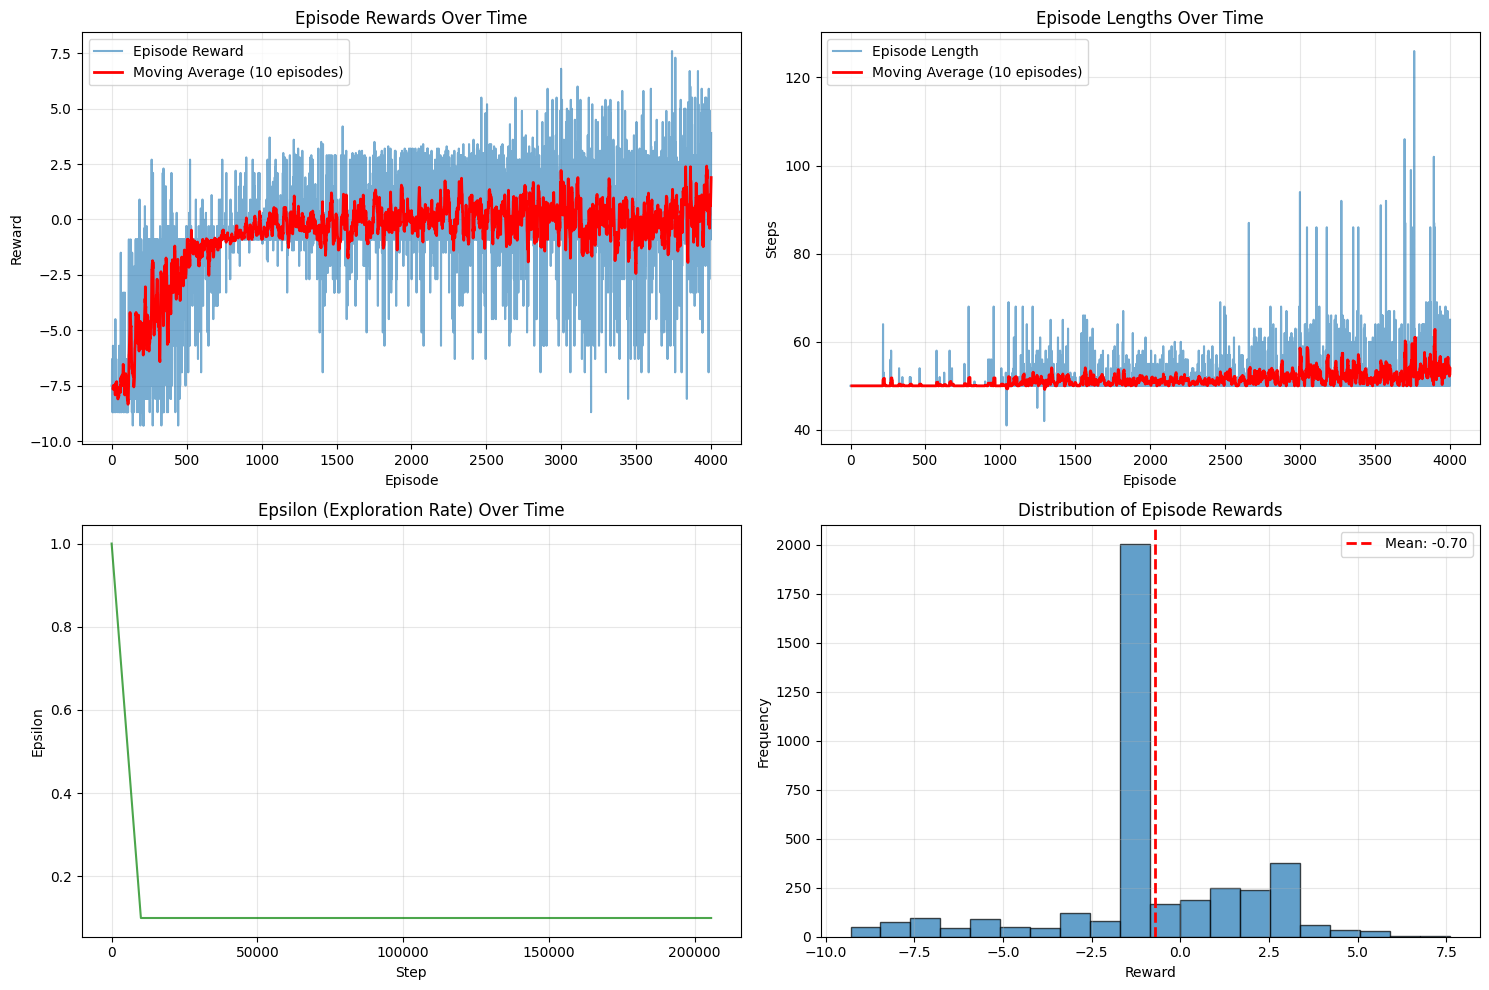


Training Summary
Total episodes: 4000
Average reward: -0.70 ± 2.66
Best episode reward: 7.60
Worst episode reward: -9.30
Average episode length: 51.4 ± 4.3
Final epsilon: 0.100
Total training steps: 204634


In [264]:
# Visualize learning trajectory
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Episode Rewards
axes[0, 0].plot(episode_rewards, alpha=0.6, label='Episode Reward')
# Moving average
if len(episode_rewards) >= 10:
    window = min(10, len(episode_rewards))
    moving_avg = np.convolve(episode_rewards, np.ones(window)/window, mode='valid')
    axes[0, 0].plot(range(window-1, len(episode_rewards)), moving_avg, 
                    'r-', linewidth=2, label=f'Moving Average ({window} episodes)')
axes[0, 0].set_xlabel('Episode')
axes[0, 0].set_ylabel('Reward')
axes[0, 0].set_title('Episode Rewards Over Time')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Episode Lengths
axes[0, 1].plot(episode_lengths, alpha=0.6, label='Episode Length')
if len(episode_lengths) >= 10:
    window = min(10, len(episode_lengths))
    moving_avg = np.convolve(episode_lengths, np.ones(window)/window, mode='valid')
    axes[0, 1].plot(range(window-1, len(episode_lengths)), moving_avg, 
                    'r-', linewidth=2, label=f'Moving Average ({window} episodes)')
axes[0, 1].set_xlabel('Episode')
axes[0, 1].set_ylabel('Steps')
axes[0, 1].set_title('Episode Lengths Over Time')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Epsilon Decay
axes[1, 0].plot(epsilon_values, 'g-', alpha=0.7)
axes[1, 0].set_xlabel('Step')
axes[1, 0].set_ylabel('Epsilon')
axes[1, 0].set_title('Epsilon (Exploration Rate) Over Time')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Reward Distribution
axes[1, 1].hist(episode_rewards, bins=20, alpha=0.7, edgecolor='black')
axes[1, 1].axvline(np.mean(episode_rewards), color='r', linestyle='--', 
                   linewidth=2, label=f'Mean: {np.mean(episode_rewards):.2f}')
axes[1, 1].set_xlabel('Reward')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of Episode Rewards')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*50)
print("Training Summary")
print("="*50)
print(f"Total episodes: {len(episode_rewards)}")
print(f"Average reward: {np.mean(episode_rewards):.2f} ± {np.std(episode_rewards):.2f}")
print(f"Best episode reward: {np.max(episode_rewards):.2f}")
print(f"Worst episode reward: {np.min(episode_rewards):.2f}")
print(f"Average episode length: {np.mean(episode_lengths):.1f} ± {np.std(episode_lengths):.1f}")
print(f"Final epsilon: {epsilon_values[-1]:.3f}")
print(f"Total training steps: {trainer.train_steps}")
print("="*50)


In [265]:
# Visualize the trained agent playing and save as GIF
import time
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
try:
    import imageio
except ImportError:
    print("Installing imageio for GIF creation...")
    import subprocess
    subprocess.check_call(["pip", "install", "imageio"])
    import imageio

def visualize_agent_playing(q_net, env, frame_buffer, num_episodes=3, max_steps=500, epsilon=0.0, save_gif=True, gif_filename="flappy_bird_agent.gif"):
    """
    Visualize the trained agent playing Flappy Bird.
    
    Args:
        q_net: Trained Q-network
        env: Environment instance
        frame_buffer: FrameBuffer instance
        num_episodes: Number of episodes to visualize
        max_steps: Maximum steps per episode
        epsilon: Exploration rate (0.0 for pure exploitation)
    """
    q_net.eval()  # Set to evaluation mode
    all_episode_frames = []  # Store frames from all episodes for GIF
    
    for episode in range(num_episodes):
        # Reset environment
        observation, info = env.reset()
        frame_buffer.reset()
        
        # Get initial state
        state = process_observation(observation, frame_buffer, env)
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        
        episode_reward = 0
        frames = []  # Store frames for visualization
        
        print(f"\nEpisode {episode + 1}/{num_episodes}")
        print("Playing...")
        
        for step in range(max_steps):
            # Select action (use epsilon for some exploration if desired)
            if np.random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    q_values = q_net(state_tensor)
                    action = q_values.argmax(1).item()
            
            # Take step
            next_observation, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            episode_reward += reward
            
            # Render and store frame
            rgb_frame = env.render()
            if rgb_frame is not None:
                frames.append(rgb_frame.copy())
            
            # Process next observation
            next_state = process_observation(next_observation, frame_buffer, env)
            next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0).to(device)
            
            # Update state
            state = next_state
            state_tensor = next_state_tensor
            
            if done:
                break
        
        print(f"Episode {episode + 1} completed!")
        print(f"  Steps: {step + 1}")
        print(f"  Total reward: {episode_reward:.2f}")
        
        # Store frames for GIF creation
        if frames:
            all_episode_frames.append(frames)
    
    # Create and save GIF
    if save_gif and all_episode_frames:
        print(f"\nCreating GIF from {sum(len(f) for f in all_episode_frames)} frames...")
        
        # Combine frames from all episodes (you can also save separate GIFs per episode)
        all_frames = []
        for episode_idx, episode_frames in enumerate(all_episode_frames):
            # Add episode separator frame (optional)
            if episode_idx > 0:
                separator = np.ones_like(episode_frames[0]) * 255
                all_frames.extend([separator] * 5)  # 5 blank frames between episodes
            
            # Add frames (can downsample to reduce file size)
            all_frames.extend(episode_frames[::2])  # Every 2nd frame to reduce size
        
        # Save as GIF
        print(f"Saving GIF with {len(all_frames)} frames to {gif_filename}...")
        imageio.mimsave(gif_filename, all_frames, fps=10, loop=0)
        print(f"✓ GIF saved as {gif_filename}!")
        
        # Also display a preview
        print("\nDisplaying preview (first 50 frames)...")
        fig, ax = plt.subplots(figsize=(10, 8))
        preview_frames = all_frames[:50:2]  # Show every 2nd frame of first 50
        for i, frame in enumerate(preview_frames):
            ax.clear()
            ax.imshow(frame)
            ax.set_title(f"Preview Frame {i*2}/{len(all_frames)}")
            ax.axis('off')
            display(fig)
            clear_output(wait=True)
            time.sleep(0.05)
        plt.close(fig)
    
    q_net.train()  # Set back to training mode
    print("\n✓ Visualization complete!")

# Run visualization with the trained model and save as GIF
# Note: If env was closed, create a new one
try:
    env.render()  # Test if env is still open
except:
    print("Creating new environment for visualization...")
    env = gym.make("FlappyBird-v0", render_mode='rgb_array')

print("="*60)
print("Visualizing Trained Agent and Saving GIF")
print("="*60)
visualize_agent_playing(
    q_net, 
    env, 
    frame_buffer, 
    num_episodes=3, 
    max_steps=1000,  # Longer episodes for better visualization
    epsilon=0.0,  # Pure exploitation
    save_gif=True,
    gif_filename="flappy_bird_agent.gif"
)



✓ Visualization complete!


In [266]:
# Alternative: Real-time visualization (simpler, shows one episode at a time)
def visualize_episode_realtime(q_net, env, frame_buffer, max_steps=500, epsilon=0.0):
    """
    Show one episode in real-time with live updates.
    """
    q_net.eval()
    
    # Reset environment
    observation, info = env.reset()
    frame_buffer.reset()
    
    # Get initial state
    state = process_observation(observation, frame_buffer, env)
    state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
    
    episode_reward = 0
    step_count = 0
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    print("Playing episode (press interrupt to stop)...")
    
    try:
        for step in range(max_steps):
            # Select action
            if np.random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    q_values = q_net(state_tensor)
                    action = q_values.argmax(1).item()
            
            # Take step
            next_observation, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            episode_reward += reward
            step_count += 1
            
            # Render and display
            rgb_frame = env.render()
            if rgb_frame is not None:
                ax.clear()
                ax.imshow(rgb_frame)
                ax.set_title(f"Step: {step_count} | Reward: {episode_reward:.2f} | Action: {'Flap' if action == 1 else 'No Flap'}")
                ax.axis('off')
                display(fig)
                clear_output(wait=True)
            
            # Process next observation
            next_state = process_observation(next_observation, frame_buffer, env)
            next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0).to(device)
            
            # Update state
            state = next_state
            state_tensor = next_state_tensor
            
            if done:
                print(f"\nEpisode ended after {step_count} steps")
                print(f"Total reward: {episode_reward:.2f}")
                break
                
    except KeyboardInterrupt:
        print(f"\nStopped after {step_count} steps")
        print(f"Total reward: {episode_reward:.2f}")
    
    plt.close(fig)
    q_net.train()
    
    return episode_reward, step_count

visualize_episode_realtime(q_net, env, frame_buffer, max_steps=500, epsilon=0.0)



Episode ended after 66 steps
Total reward: 5.20


(5.199999999999994, 66)